# "Optimization for Statistical Learning" Expirement Notebook
## Section 0 Introduction

### Section 0.1 Data Importing and Preprocessing
In this section, we include packages we will use in this notebook.

In [1]:
# Install packages #
# !pip install jupyter
# !pip install numpy
# !pip install matplotlib
# !pip install math
# !pip install torch
# !pip install xlrd
# !pip install pandas
# !pip install torchvision

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import math
import copy
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch import Tensor
from torch.optim.optimizer import (Optimizer, required, _use_grad_for_differentiable, _default_to_fused_or_foreach,
                        _differentiable_doc, _foreach_doc, _maximize_doc)
from typing import List, Optional
from torch.autograd import Variable

## Section 0.2 Global Classes, Functions and Algorithms

**Spliting the DataLoader**

In [3]:
def split_dataloader(dataloader, num_piece):
    dataset = list(dataloader)
    subset_size = len(dataset) // num_piece
    remainder = len(dataset) % num_piece
    split_subsets = []
    start_idx = 0
    for i in range(num_piece):
        if i < remainder:
            end_idx = start_idx + subset_size + 1
        else:
            end_idx = start_idx + subset_size
        subset = dataset[start_idx:end_idx]
        split_subsets.append(subset)
        start_idx = end_idx
    split_dataloaders = []
    for subset in split_subsets:
        split_dataloader = torch.utils.data.DataLoader(subset, batch_size=dataloader.batch_size, shuffle=True)
        split_dataloaders.append(split_dataloader)
    return split_dataloaders

**Error Rate Analaysis**

In [4]:
# Train and test error rate analysis function
def calculate_error_rate(X, y, predict):
    num_samples = X.shape[0]
    error_count = torch.count_nonzero(torch.round(predict) - y)
    error_rate = error_count / num_samples
    return error_rate

**Custom Optimizer Class of Vanilia Gradient Descent**

The name custom_optimizer_SGD is just for consistency with torch.optim.SGD

In [5]:
class custom_optimizer_SGD(Optimizer):
    def __init__(self, params, lr=required, weight_decay=0 ):
        if lr is not required and lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super().__init__(params, defaults)
                
    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad.data
                weight_decay = group['weight_decay']
                lr = group['lr']
                param.data.add_(-lr, grad)
                if weight_decay != 0:
                    param.data.add_(-lr * weight_decay, param.data)

**Client Device Class and Federated Learning Algorithms**

In [71]:
# Define a custom class for each client so they can update separately
class ClientDevice:
    def __init__(self, model, criterion, optimizer, X_train, y_train):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.X_train = X_train
        self.y_train = y_train
        self.num_samples = self.X_train.size()[0]
        self.num_features = self.X_train.size()[1]

    def load_global_weights(self, global_weights):
        self.model.load_state_dict(global_weights)

    def get_local_weights(self):
        return self.model.state_dict()

    def update_weights_GDVanilia(self, num_epochs):
        self.model.train()
        for epoch in range(num_epochs):
            # Update weight
            outputs = self.model(self.X_train.float())
            loss = self.criterion(outputs, self.y_train.float())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return self.model.state_dict()
    
    def update_weights_GDStochastic(self, num_epochs, batch_size):
        self.model.train()
        num_batches = self.num_samples // batch_size
        for epoch in range(num_epochs):
            # Shuffle the data for each epoch
            permutation = torch.randperm(self.num_samples)
            X_shuffled = self.X_train[permutation]
            y_shuffled = self.y_train[permutation]
            for batch in range(num_batches):
                # Select the current batch
                start = batch * batch_size
                end = (batch + 1) * batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                # Update weight
                outputs = self.model(X_batch.float())
                loss = self.criterion(outputs, y_batch.float())
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        return self.model.state_dict()
    
    def update_weights(self, num_epochs, input_shape, iterate_func):
        self.model.train()
        loss_history, error_history = iterate_func(self.model, self.train_loader, num_epochs, self.optimizer, self.criterion, input_shape, show_history=False, training=True)
        return self.model.state_dict(), loss_history, error_history

# Establish client devices
def establish_client_devices(num_clients, dataset_loader, model_list, optimizer_list, criterion_list):
    # Establish client devices
    client_device = [None] * num_clients
    client_model = [None] * num_clients
    client_optimizer = [None] * num_clients
    client_criterion = [None] * num_clients
    client_weights = [None] * num_clients
    for client in range(num_clients):
        client_model[client] = model_list[client]
        client_optimizer[client] = optimizer_list[client]
        client_criterion[client] = criterion_list[client]
        client_weights[client] = client_model[client].state_dict()
        client_device[client] = ClientDevice(client_model[client], client_optimizer[client], client_criterion[client], dataset_loader)
    return client_device
    

# Define server wise functions
def send_client_weights(server_weights, local_weights):
    server_weights.append(local_weights)

# Total weight processing functions
def Federated_Averaging(client_weights_total):
    total_clients = len(client_weights_total)
    aggregate_weights = {}

    # Initialize aggregate_weights with the first client's weights
    for layer_name, layer_weights in client_weights_total[0].items():
        aggregate_weights[layer_name] = layer_weights / total_clients

    # Aggregate weights from the remaining clients
    for client_weights in client_weights_total[1:]:
        for layer_name, layer_weights in client_weights.items():
            aggregate_weights[layer_name] += layer_weights / total_clients

    return aggregate_weights

## Section 1. Linear Training Model
In this section, we will focus on the dataset requires no complicated data processing, and mainly linear models.

### Section 1.0. Data Loading and Preprocessing
Here we load the data for the expriements.

**BMI Dataset**

In [72]:
### BMI Dataset

# Loading training data
dataset = pd.read_csv("bmi_train.csv")
dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
dataset = dataset.to_numpy()

# Splitting off 80% of data for training, 20% for validation
train_split = int(0.8 * len(dataset))
X_train = dataset[:train_split, [0,1,2]]
y_train = dataset[:train_split, 3]
X_test = dataset[train_split:, [0,1,2]]
y_test = dataset[train_split:, 3]
print(X_train)
print(y_train)

# Loading prediction data
prediction_dataset = pd.read_csv("bmi_validation.csv")
prediction_dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
X_prediction = prediction_dataset.to_numpy()

# Normalize data set
X_train_normalized = (X_train - X_train.min(0)) / (X_train.max(0) - X_train.min(0))
X_test_normalized = (X_test - X_test.min(0)) / (X_test.max(0) - X_test.min(0))
X_prediction_normalized = (X_prediction - X_prediction.min(0)) / (X_prediction.max(0) - X_prediction.min(0))

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train_normalized)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test_normalized)
y_test_tensor = torch.from_numpy(y_test)
X_prediction_tensor = torch.from_numpy(X_prediction_normalized)
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

# Learning Rate and Batch size
dataset_name = "BMI Datset"
learning_rate_preset = 0.01
batch_size_preset = 10

[[  1 161  89]
 [  1 179 127]
 [  1 172 139]
 [  1 153 104]
 [  1 165  68]
 [  1 172  92]
 [  1 182 108]
 [  1 179 130]
 [  1 142  71]
 [  0 158 153]
 [  1 194 108]
 [  0 178 107]
 [  1 155  57]
 [  0 151  64]
 [  0 181  80]
 [  0 147 126]
 [  0 142 159]
 [  1 165 155]
 [  0 146 104]
 [  1 157  56]
 [  0 173  82]
 [  0 170 102]
 [  0 190 118]
 [  0 168 140]
 [  0 153  78]
 [  1 188 123]
 [  0 162  64]
 [  1 182 104]
 [  1 194 115]
 [  0 185 102]
 [  1 178  52]
 [  0 192  90]
 [  1 147 142]
 [  1 152 103]
 [  0 169  54]
 [  1 178 127]
 [  1 165 105]
 [  0 172  67]
 [  1 140 129]
 [  1 141  86]
 [  0 172  96]
 [  1 191  96]
 [  0 147 107]
 [  1 197 119]
 [  0 162 159]
 [  1 173 139]
 [  1 185 139]
 [  0 152  90]
 [  1 163 131]
 [  1 188 141]
 [  1 189 104]
 [  0 165  57]
 [  1 185  76]
 [  0 157 110]
 [  1 179  56]
 [  0 186 143]
 [  0 195 104]
 [  0 141 126]
 [  1 148 141]
 [  0 191  54]
 [  0 150  70]
 [  1 170  95]
 [  0 153  77]
 [  1 179 152]
 [  1 184 157]
 [  1 154 112]
 [  1 190 

**Epsilon Pascal Challenge Dataset**

In [ ]:
### Epsilon Pascal Challenge Dataset

# Loading training data
dataset = pd.read_csv("epsilon_normalized", sep=' ', header=None, nrows=20000)
dataset = dataset.to_numpy()
for i in range(1, dataset.shape[1]-1):
    dataset[:, i] = [float(value.split(':')[1]) if isinstance(value, str) else value for value in dataset[:, i]]
dataset = dataset[:, :-1]
np.random.shuffle(dataset)

for i in range(1, dataset.shape[0]):
    if dataset[i - 1, 0] == -1:
        dataset[i - 1, 0] = 0

# Splitting off data for training and validation
train_split = int(0.8 * len(dataset))
X_train = dataset[:train_split, 1:].astype(np.float32)
y_train = dataset[:train_split, 0].astype(np.float32)
X_test = dataset[train_split:, 1:].astype(np.float32)
y_test = dataset[train_split:, 0].astype(np.float32)
print(X_train)
print(y_train)

# Normalize data set
X_train_normalized = X_train
X_test_normalized = X_test

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train_normalized)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test_normalized)
y_test_tensor = torch.from_numpy(y_test)
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

# Preset parameters
dataset_name = "Epsilon Datset"
learning_rate_preset = 0.001
batch_size_preset = 10

**Gisette Dataset**

In [ ]:
### gisette Dataset
#2 class, 6000 data points, ~5000 features

# Loading training data
dataset = pd.read_csv("gisette_scale", sep=' ', header=None)
dataset = dataset.to_numpy()
for i in range(1, dataset.shape[1]-1):
    dataset[:, i] = [float(value.split(':')[1]) if isinstance(value, str) else value for value in dataset[:, i]]
dataset = dataset[:, :-2]
np.random.shuffle(dataset)

for i in range(1, dataset.shape[0]):
    if dataset[i - 1, 0] == -1:
        dataset[i - 1, 0] = 0

#print(dataset)
#print(dataset.shape)

# Splitting off data for training and validation
train_split = int(0.8 * len(dataset))
X_train = dataset[:train_split, 1:].astype(np.float32)
y_train = dataset[:train_split, 0].astype(np.float32)
X_test = dataset[train_split:, 1:].astype(np.float32)
y_test = dataset[train_split:, 0].astype(np.float32)
print(X_train)
print(y_train)

# Normalize data set
denominator = X_train.max(0) - X_train.min(0)
X_train_normalized = (X_train - X_train.min(0)) / np.where(denominator != 0, denominator, 1)
denominator = X_test.max(0) - X_test.min(0)
X_test_normalized = (X_test - X_test.min(0)) / np.where(denominator != 0, denominator, 1)

print("X_train_normalized: ", X_train_normalized)
print("X_test_normalized: ", X_test_normalized)

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train_normalized)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test_normalized)
y_test_tensor = torch.from_numpy(y_test)
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

# Learning Rate and Batch size
dataset_name = "Gisette Datset"
learning_rate_preset = 0.005
batch_size_preset = 100

### Section 1.1. Vanilia Gradient Descent and Stochastic Gradient Descent

Initially test training dataset with custom algorithms and pytorch package. We will verify our result of our algorithms by comparing the pytorch package.

**Custom Algorithm for Vanilia Gradient Descent**

Current Dataset: BMI Datset
Epoch [1/100], Loss: 15.80625000, Error: 0.9750000238418579
Epoch [10/100], Loss: 11.84453963, Error: 0.9624999761581421
Epoch [20/100], Loss: 8.74042020, Error: 0.9499999880790710
Epoch [30/100], Loss: 6.59125096, Error: 0.9406250119209290
Epoch [40/100], Loss: 5.10072375, Error: 0.9062500000000000
Epoch [50/100], Loss: 4.06452784, Error: 0.8625000119209290
Epoch [60/100], Loss: 3.34178497, Error: 0.8562499880790710
Epoch [70/100], Loss: 2.83535392, Error: 0.8281250000000000
Epoch [80/100], Loss: 2.47825034, Error: 0.7781249880790710
Epoch [90/100], Loss: 2.22428333, Error: 0.7562500238418579
Epoch [100/100], Loss: 2.04159921, Error: 0.7781249880790710
Learned parameters:
w0 = 0.7893282862904447
w1 = 0.7069466630766956
w2 = 1.1345527463229768
b = 1.756049608200005


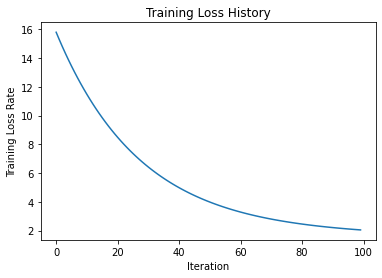

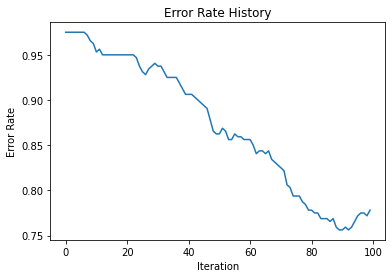

Train error rate: tensor(0.7750)
Test error rate: tensor(0.7625)


In [73]:
# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Vanilia Gradient Descent Algorithms
def gradient_descent(X, y, learning_rate, num_epochs):
    num_samples, num_features = X.shape
    
    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0

    loss_history = []
    error_history = []
    
    for epoch in range(num_epochs):
        # Calculate predictions
        y_pred = np.dot(X, w) + b
        
        # Calculate the difference between predictions and actual values
        error = y_pred - y
        
        # Calculate the gradient
        w_gradient = (1/num_samples) * np.dot(X.T, error)
        b_gradient = (1/num_samples) * np.sum(error)
        
        # Update theta using the learning rate and gradient
        w -= learning_rate * w_gradient
        b -= learning_rate * b_gradient

        # Record the loss
        loss = np.mean(np.square(error))
        loss_history.append(loss)

        # Record the error rate
        train_error_rate = calculate_error_rate(X_train_normalized,  y_train, torch.from_numpy(y_pred))
        error_history.append(train_error_rate)

        # Print the loss every specific epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate:.16f}')
    
    return w, b, loss_history, error_history

# Train the model using gradient descent
learning_rate = learning_rate_preset
num_iterations = 100
w, b, loss_history, error_history = gradient_descent(X_train_normalized, y_train, learning_rate, num_iterations)

# Print the learned parameters
print("Learned parameters:")

for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the training loss history
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss History")
plt.show()

# Plot the error rate history
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error Rate")
plt.title("Error Rate History")
plt.show()

# Calculate train error rate
y_pred = np.dot(X_train_normalized, w) + b
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, torch.from_numpy(y_pred))
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    y_pred = np.dot(X_test_normalized, w) + b
    test_error_rate = calculate_error_rate(X_test_normalized,  y_test, torch.from_numpy(y_pred))
    print("Test error rate:", test_error_rate)

**Custom Algorithm for Stochastic Gradient Descent**

Current Dataset: BMI Datset
Epoch [1/1000], Loss: 2.77353939, Error: 0.9312499761581421
Epoch [10/1000], Loss: 13.85729658, Error: 0.7031250000000000
Epoch [20/1000], Loss: 14.18640205, Error: 0.5812500119209290
Epoch [30/1000], Loss: 14.38938007, Error: 0.4749999940395355
Epoch [40/1000], Loss: 14.60931434, Error: 0.4468750059604645
Epoch [50/1000], Loss: 14.78304080, Error: 0.4281249940395355
Epoch [60/1000], Loss: 14.94671294, Error: 0.4312500059604645
Epoch [70/1000], Loss: 15.02085327, Error: 0.4218750000000000
Epoch [80/1000], Loss: 15.12527588, Error: 0.4124999940395355
Epoch [90/1000], Loss: 15.19689475, Error: 0.4093750119209290
Epoch [100/1000], Loss: 15.27951639, Error: 0.3968749940395355
Epoch [110/1000], Loss: 15.32129597, Error: 0.3937500119209290
Epoch [120/1000], Loss: 15.33884955, Error: 0.3937500119209290
Epoch [130/1000], Loss: 15.42772290, Error: 0.3874999880790710
Epoch [140/1000], Loss: 15.38027105, Error: 0.3843750059604645
Epoch [150/1000], Loss: 15.43731979, Er

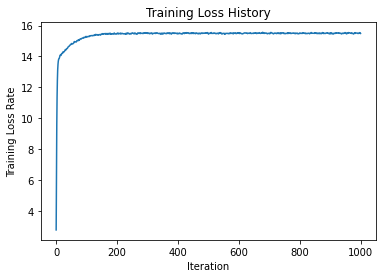

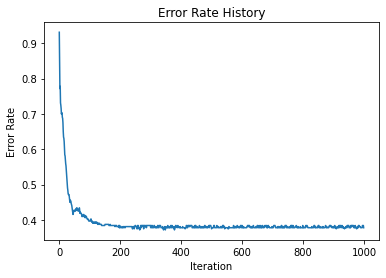

Train error rate: tensor(0.3781)
Test error rate: tensor(0.3625)


In [74]:
# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Stochastic Gradient Descent Algorithms
def stochastic_gradient_descent(X, y, learning_rate, num_epochs, batch_size):
    num_samples, num_features = X.shape
    num_batches = num_samples // batch_size

    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0
    
    loss_history = []
    error_history = []

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch
        permutation = np.random.permutation(num_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for batch in range(num_batches):
            # Select the current batch
            start = batch * batch_size
            end = (batch + 1) * batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Calculate predictions
            y_pred = np.dot(X_batch, w) + b

            # Calculate the difference between predictions and actual values
            error = y_pred - y_batch

            # Calculate the gradients
            w_gradient = (1 / batch_size) * np.dot(X_batch.T, error)
            b_gradient = (1 / batch_size) * np.sum(error)

            # Update weights and bias
            w -= learning_rate * w_gradient
            b -= learning_rate * b_gradient
        
        # General Output
        y_pred = np.dot(X_train_normalized, w) + b
        error = y_pred - y_train

        # Record the loss
        error = y_pred
        loss = np.mean(np.square(error))
        loss_history.append(loss)

        # Record the error rate
        train_error_rate = calculate_error_rate(X_train_normalized,  y_train, torch.from_numpy(y_pred))
        error_history.append(train_error_rate)

        # Print the loss every specific epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate:.16f}')
            
    return w, b, loss_history, error_history

# Train the model using stochastic gradient descent
learning_rate = learning_rate_preset
num_epochs = 1000
batch_size = batch_size_preset
w, b, loss_history, error_history = stochastic_gradient_descent(X_train_normalized, y_train, learning_rate, num_epochs, batch_size)

# Print the learned parameters
print("Learned parameters:")
for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the training loss history
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss History")
plt.show()

# Plot the error rate history
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error Rate")
plt.title("Error Rate History")
plt.show()

# Calculate train error rate
y_pred = np.dot(X_train_normalized, w) + b
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, torch.from_numpy(y_pred))
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    y_pred = np.dot(X_test_normalized, w) + b
    test_error_rate = calculate_error_rate(X_test_normalized,  y_test, torch.from_numpy(y_pred))
    print("Test error rate:", test_error_rate)

**Pytorch Package for Vanilia Gradient Descent**

(It is just a Vanilia Gradient Descent... They call it SGD is confusing...)

Current Dataset: BMI Datset
Epoch [1/1000], Loss: 15.80624962, Error: 0.9750000238418579
Epoch [10/1000], Loss: 8.95719337, Error: 0.9499999880790710
Epoch [20/1000], Loss: 5.18171310, Error: 0.9125000238418579
Epoch [30/1000], Loss: 3.37053919, Error: 0.8562499880790710
Epoch [40/1000], Loss: 2.48795056, Error: 0.7812500000000000
Epoch [50/1000], Loss: 2.04493523, Error: 0.7781249880790710
Epoch [60/1000], Loss: 1.81057477, Error: 0.7812500000000000
Epoch [70/1000], Loss: 1.67579579, Error: 0.7593749761581421
Epoch [80/1000], Loss: 1.58904791, Error: 0.7312499880790710
Epoch [90/1000], Loss: 1.52594018, Error: 0.7218750119209290
Epoch [100/1000], Loss: 1.47490764, Error: 0.7218750119209290
Epoch [110/1000], Loss: 1.43044233, Error: 0.7187500000000000
Epoch [120/1000], Loss: 1.38989937, Error: 0.7031250000000000
Epoch [130/1000], Loss: 1.35198796, Error: 0.6999999880790710
Epoch [140/1000], Loss: 1.31605935, Error: 0.7062500119209290
Epoch [150/1000], Loss: 1.28177118, Error: 0.6999999

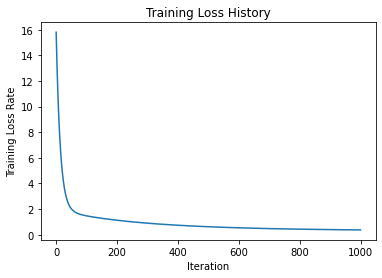

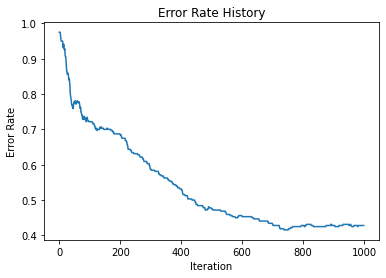

Train error rate: tensor(0.4281)
Test error rate: tensor(0.3250)


In [75]:
### Pytorch Vanilia Gradient Descent

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs
learning_rate = learning_rate_preset
num_epochs = 1000

# Define the number of features
num_features = X_train_tensor.size()[1]

# Define the model parameters (weights and bias)
w = torch.zeros(num_features, dtype=torch.float, requires_grad=True)
# w = torch.tensor([1., 1., 1.], requires_grad=True)
b = torch.zeros(1, dtype=torch.float, requires_grad=True)
# b = torch.tensor([1.], requires_grad=True)

loss_history = []
error_history = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer (Vanilla Gradient Descent)
optimizer = torch.optim.SGD([w, b], lr=learning_rate, weight_decay=0)

# Perform gradient descent
for epoch in range(num_epochs):
    # Forward pass
    outputs = torch.matmul(X_train_tensor.float(), w) + b
    loss = criterion(outputs, y_train_tensor.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record the loss
    loss_history.append(loss.detach().numpy())
    
    # Record the error rate
    train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
    error_history.append(train_error_rate)

    # Print the loss every specific epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate:.16f}')
        

# Print learned parameters
print('Trained weights:', w)
print('Trained bias:', b)

# Plot the training loss history
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss History")
plt.show()

# Plot the error rate history
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error Rate")
plt.title("Error Rate History")
plt.show()

# Calculate train error rate
outputs = torch.matmul(X_train_tensor.float(), w) + b
train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    outputs = torch.matmul(X_test_tensor.float(), w) + b
    test_error_rate = calculate_error_rate(X_test_tensor,  y_test_tensor, outputs)
    print("Test error rate:", test_error_rate)

**Pytorch Package for Stochastic Gradient Descent**

Current Dataset: BMI Datset
Epoch [1/500], Loss: 3.07215071, Error: 0.8437500000000000
Epoch [10/500], Loss: 0.85702896, Error: 0.5812500119209290
Epoch [20/500], Loss: 0.50810432, Error: 0.4468750059604645
Epoch [30/500], Loss: 0.38088974, Error: 0.4312500059604645
Epoch [40/500], Loss: 0.33295646, Error: 0.4124999940395355
Epoch [50/500], Loss: 0.31467071, Error: 0.3968749940395355
Epoch [60/500], Loss: 0.30763015, Error: 0.3968749940395355
Epoch [70/500], Loss: 0.30483526, Error: 0.3843750059604645
Epoch [80/500], Loss: 0.30388156, Error: 0.3843750059604645
Epoch [90/500], Loss: 0.30330056, Error: 0.3843750059604645
Epoch [100/500], Loss: 0.30312580, Error: 0.3843750059604645
Epoch [110/500], Loss: 0.30303064, Error: 0.3781250119209290
Epoch [120/500], Loss: 0.30300230, Error: 0.3812499940395355
Epoch [130/500], Loss: 0.30306715, Error: 0.3718749880790710
Epoch [140/500], Loss: 0.30325761, Error: 0.3718749880790710
Epoch [150/500], Loss: 0.30298084, Error: 0.3781250119209290
Epoch [

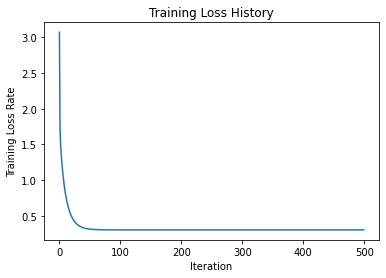

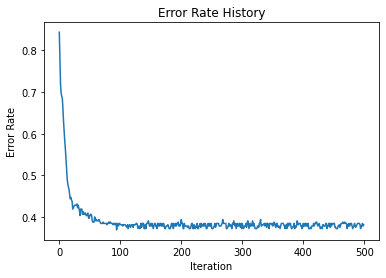

Train error rate: tensor(0.3812)
Test error rate: tensor(0.3625)


In [76]:
### Pytorch Stochastic Gradient Descent

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs and batch size
learning_rate = learning_rate_preset
num_epochs = 500
batch_size = batch_size_preset

# Define the number of samples and features
num_samples  = X_train_tensor.size()[0]
num_features = X_train_tensor.size()[1]

# Define the model parameters (weights and bias)
w = torch.zeros(num_features, dtype=torch.float, requires_grad=True)
# w = torch.tensor([1., 1., 1.], requires_grad=True)
b = torch.zeros(1, dtype=torch.float, requires_grad=True)
# b = torch.tensor([1.], requires_grad=True)

loss_history = []
error_history = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer (Vanilla Gradient Descent)
optimizer = torch.optim.SGD([w, b], lr=learning_rate, weight_decay=0)

# Perform stochastic gradient descent
num_batches = num_samples // batch_size
for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    permutation = torch.randperm(num_samples)
    X_shuffled = X_train_tensor[permutation]
    y_shuffled = y_train_tensor[permutation]
    for batch in range(num_batches):
        # Select the current batch
        start = batch * batch_size
        end = (batch + 1) * batch_size
        X_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]

        # Forward pass
        outputs = torch.matmul(X_batch.float(), w) + b
        loss = criterion(outputs, y_batch.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # General Output
    outputs = torch.matmul(X_train_tensor.float(), w) + b
    loss = criterion(outputs, y_train_tensor.float())

    # Record the loss
    loss_history.append(loss.detach().numpy())
    
    # Record the error rate
    train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
    error_history.append(train_error_rate)

    # Print the loss every specific epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate:.16f}')

# Print learned parameters
print('Trained weights:', w)
print('Trained bias:', b)

# Plot the training loss history
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss History")
plt.show()

# Plot the error rate history
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error Rate")
plt.title("Error Rate History")
plt.show()

# Calculate train error rate
outputs = torch.matmul(X_train_tensor.float(), w) + b
train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    outputs = torch.matmul(X_test_tensor.float(), w) + b
    test_error_rate = calculate_error_rate(X_test_tensor,  y_test_tensor, outputs)
    print("Test error rate:", test_error_rate)

### Section 1.2. Linear Neural Network

**Neural Network**

This neural network is simply a linear model.

In [77]:
# Define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, num_features=1):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation_stack = nn.Sequential(
            nn.Linear(num_features, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.activation_stack(x)
        return torch.squeeze(logits)

**Linear Neural Network with Vanilia Gradient Descent**

Current Dataset: BMI Datset
320
3
6
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation_stack): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
  )
)
Epoch [1/1000], Loss: 15.76810455, Error: 0.9750000238418579
Epoch [10/1000], Loss: 8.79030037, Error: 0.9499999880790710
Epoch [20/1000], Loss: 4.95060253, Error: 0.9312499761581421
Epoch [30/1000], Loss: 3.11525512, Error: 0.8562499880790710
Epoch [40/1000], Loss: 2.22709608, Error: 0.7875000238418579
Epoch [50/1000], Loss: 1.78700900, Error: 0.7468749880790710
Epoch [60/1000], Loss: 1.55932307, Error: 0.7593749761581421
Epoch [70/1000], Loss: 1.43273687, Error: 0.7218750119209290
Epoch [80/1000], Loss: 1.35466278, Error: 0.7093750238418579
Epoch [90/1000], Loss: 1.30023503, Error: 0.6968749761581421
Epoch [100/1000], Loss: 1.25767589, Error: 0.6875000000000000
Epoch [110/1000], Loss: 1.22138953, Error: 0.6718750000000000
Epoch [120/1000], Loss: 1.18870020, Error: 0.6687499880790710
Epoch [13

C:\Users\chris\AppData\Local\Temp\ipykernel_18004\304550788.py:18: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1519.)
  param.data.add_(-lr, grad)


Epoch [240/1000], Loss: 0.89860773, Error: 0.5812500119209290
Epoch [250/1000], Loss: 0.87986881, Error: 0.5749999880790710
Epoch [260/1000], Loss: 0.86178225, Error: 0.5656250119209290
Epoch [270/1000], Loss: 0.84432113, Error: 0.5593749880790710
Epoch [280/1000], Loss: 0.82745945, Error: 0.5593749880790710
Epoch [290/1000], Loss: 0.81117260, Error: 0.5593749880790710
Epoch [300/1000], Loss: 0.79543763, Error: 0.5500000119209290
Epoch [310/1000], Loss: 0.78023225, Error: 0.5500000119209290
Epoch [320/1000], Loss: 0.76553553, Error: 0.5468750000000000
Epoch [330/1000], Loss: 0.75132781, Error: 0.5343750119209290
Epoch [340/1000], Loss: 0.73759019, Error: 0.5281249880790710
Epoch [350/1000], Loss: 0.72430432, Error: 0.5218750238418579
Epoch [360/1000], Loss: 0.71145368, Error: 0.5187500119209290
Epoch [370/1000], Loss: 0.69902152, Error: 0.5031250119209290
Epoch [380/1000], Loss: 0.68699253, Error: 0.5000000000000000
Epoch [390/1000], Loss: 0.67535162, Error: 0.4937500059604645
Epoch [4

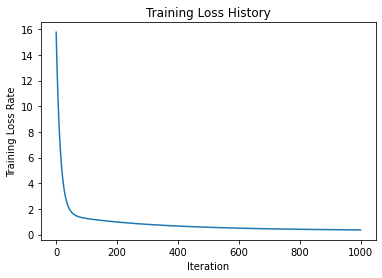

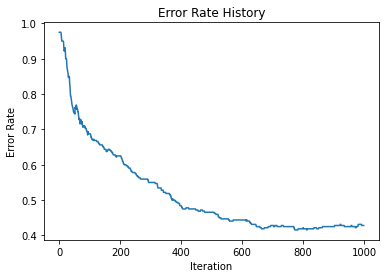

Train error rate: tensor(0.4281)
Test error rate: tensor(0.3250)


In [78]:
### Neural Network with Vanilia Gradient Descent

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs
learning_rate = learning_rate_preset
num_epochs = 1000

# Define the number of samples and features
num_samples  = X_train_tensor.size()[0]
num_features = X_train_tensor.size()[1]
num_class = len(torch.unique(y_train_tensor))
print(num_samples)
print(num_features)
print(num_class)

# Define the model parameters
loss_history = []
error_history = []

# Define neural network model, loss criterion and optimizer
criterion = torch.nn.MSELoss()
model = NeuralNetwork(num_features)
print(model)
optimizer = custom_optimizer_SGD(model.parameters(), lr=learning_rate, weight_decay = 0)

#for name, param in NeuralNetwork_model.named_parameters():
#    print( name )
#    values = torch.ones( param.shape )
#    param.data = values
    
# Perform training
model.train()
for epoch in range(num_epochs):
    # Forward propagation to obtain the predicted output
    outputs = model(X_train_tensor.float())
    
    # Calculate the loss
    loss = criterion(outputs, y_train_tensor.float())
    
    # Backward propagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record the loss
    loss_history.append(loss.detach().numpy())
    
    # Record the error rate
    train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
    error_history.append(train_error_rate)
    
    # Print the loss every specific epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate:.16f}')
        
# Print learned parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data}')
        
# Plot the training loss history
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss History")
plt.show()

# Plot the error rate history
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error Rate")
plt.title("Error Rate History")
plt.show()

# Calculate train error rate
outputs = model(X_train_tensor.float())
train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    outputs = model(X_test_tensor.float())
    test_error_rate = calculate_error_rate(X_test_tensor,  y_test_tensor, outputs)
    print("Test error rate:", test_error_rate)

**Linear Neural Network with Stochastic Gradient Descent**

Current Dataset: BMI Datset
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation_stack): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
  )
)
Epoch [1/1000], Loss: 3.30192828, Error: 0.8687499761581421
Epoch [10/1000], Loss: 0.81300592, Error: 0.5562499761581421
Epoch [20/1000], Loss: 0.48684344, Error: 0.4375000000000000
Epoch [30/1000], Loss: 0.37264758, Error: 0.4218750000000000
Epoch [40/1000], Loss: 0.32983267, Error: 0.4124999940395355
Epoch [50/1000], Loss: 0.31343082, Error: 0.4000000059604645
Epoch [60/1000], Loss: 0.30716759, Error: 0.3906250000000000
Epoch [70/1000], Loss: 0.30469543, Error: 0.3843750059604645
Epoch [80/1000], Loss: 0.30370203, Error: 0.3843750059604645
Epoch [90/1000], Loss: 0.30324608, Error: 0.3843750059604645
Epoch [100/1000], Loss: 0.30317980, Error: 0.3843750059604645
Epoch [110/1000], Loss: 0.30301881, Error: 0.3812499940395355
Epoch [120/1000], Loss: 0.30299681, Error: 0.3812499940395355
Epoch [130/1000], 

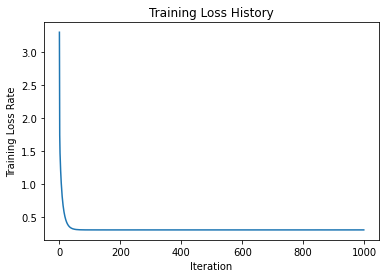

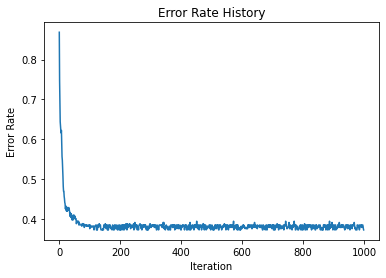

Train error rate: tensor(0.3719)
Test error rate: tensor(0.3625)


In [79]:
### Neural Network with Stochastic Gradient Descent

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs and batch size
learning_rate = learning_rate_preset
num_epochs = 1000
batch_size = batch_size_preset

# Define the number of samples and features
num_samples  = X_train_tensor.size()[0]
num_features = X_train_tensor.size()[1]

# Define the model parameters
loss_history = []
error_history = []

# Define neural network model, loss criterion and optimizer
criterion = torch.nn.MSELoss()
model = NeuralNetwork(num_features)
print(model)
optimizer = custom_optimizer_SGD(model.parameters(), lr=learning_rate, weight_decay = 0)

#for name, param in NeuralNetwork_model.named_parameters():
#    print( name )
#    values = torch.ones( param.shape )
#    param.data = values
    
# Perform training
model.train()
num_batches = num_samples // batch_size
for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    permutation = torch.randperm(num_samples)
    X_shuffled = X_train_tensor[permutation]
    y_shuffled = y_train_tensor[permutation]
    for batch in range(num_batches):
        # Select the current batch
        start = batch * batch_size
        end = (batch + 1) * batch_size
        X_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]

        # Forward propagation to obtain the predicted output
        outputs = model(X_batch.float())
    
        # Calculate the loss
        loss = criterion(outputs, y_batch.float())
    
        # Backward propagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # General Output
    outputs = model(X_train_tensor.float())
    loss = criterion(outputs, y_train_tensor.float())

    # Record the loss
    loss_history.append(loss.detach().numpy())
    
    # Record the error rate
    train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
    error_history.append(train_error_rate)

    # Print the loss every specific epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate:.16f}')
        
# Print learned parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data}')
        
# Plot the training loss history
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss History")
plt.show()

# Plot the error rate history
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error Rate")
plt.title("Error Rate History")
plt.show()

# Calculate train error rate
outputs = model(X_train_tensor.float())
train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    outputs = model(X_test_tensor.float())
    test_error_rate = calculate_error_rate(X_test_tensor,  y_test_tensor, outputs)
    print("Test error rate:", test_error_rate)

### Section 1.3. Fedearted Learning

#### Section 1.3.1 Fedearted Learning Training

**Training function for Federated Learning with Vanilia Gradient Descent**

In [80]:
### Federated Learning Training with vanilia gradient descent method
def FedLearnTrainGDVanilia(num_clients, local_update_epochs, loss_cost_history_total, error_cost_history_total, send_cost_history_total):
    # Define neural network model, loss criterion and optimizer
    model = NeuralNetwork(X_train_tensor.size()[1])
    criterion = torch.nn.MSELoss()
    optimizer = custom_optimizer_SGD(model.parameters(), lr=learning_rate)

    # Preprocess the client data
    X_train_client = [None] * num_clients
    y_train_client = [None] * num_clients
    client_row = math.floor( X_train_tensor.size(dim=0) / num_clients )
    for client in range(num_clients):
        X_train_client[client] = X_train_tensor[(client)*client_row : (client+1)*client_row]
        y_train_client[client] = y_train_tensor[(client)*client_row : (client+1)*client_row]

    # Establish client devices
    client_model = [None] * num_clients
    client_optimizer = [None] * num_clients
    client_device = [None] * num_clients
    client_weights = [None] * num_clients
    for client in range(num_clients):
        client_model[client] = NeuralNetwork(X_train_client[client].size()[1])
        client_optimizer[client] = custom_optimizer_SGD(client_model[client].parameters(), lr=learning_rate)
        client_device[client] = ClientDevice(client_model[client], criterion, client_optimizer[client], X_train_client[client], y_train_client[client])

    # Cost History
    loss_cost_history = []
    error_cost_history = []
    send_cost_history = []
    send_cost = 0

    # Perform training
    global_weights = model.state_dict()
    #print(f'Initial global weights are: {global_weights}')
    for epoch in range(num_epochs):
        client_weights_total = []

        # Clients local update
        for client in range(num_clients):
            # Transmit the global weight to clients
            client_device[client].load_global_weights(global_weights)
            client_weights[client] = client_device[client].update_weights_GDVanilia(local_update_epochs)

            # Send client weights to the server
            send_client_weights(client_weights_total, client_weights[client])
            client_weights_size = sum(len(value) for value in client_weights[client].values())
            send_cost = send_cost + client_weights_size

        # Aggregate client weights on the server
        aggregated_weights = Federated_Averaging(client_weights_total)

        # Update global weights with aggregated weights
        global_weights.update(aggregated_weights)
        model.load_state_dict(global_weights)

        # General Output
        outputs = model(X_train_tensor.float())
        loss = criterion(outputs, y_train_tensor.float())

        # Record the loss
        loss_cost_history.append(loss.item())

        # Record the error rate
        train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
        error_cost_history.append(train_error_rate)

        # Record the send cost
        send_cost_history.append(send_cost)

        # Print the loss every specific epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate:.16f}, Culminative Send Cost: {send_cost}')

    # Print learned parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')

    # Plot send cost history
    plt.plot(send_cost_history)
    plt.xlabel("Iteration")
    plt.ylabel("Send Cost")
    plt.title("Send Cost History")
    plt.show()
    print(f'Total send cost: {send_cost}')

    # Plot the training loss history
    plt.plot(loss_cost_history)
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss Rate")
    plt.title("Training Loss History")
    plt.show()

    # Plot the error rate history
    plt.plot(error_cost_history)
    plt.xlabel("Iteration")
    plt.ylabel("Error Rate")
    plt.title("Error Rate History")
    plt.show()

    # Calculate train error rate
    outputs = model(X_train_tensor.float())
    train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
    print("Train error rate:", train_error_rate)
        
    # Calculate test error rate if test data is provided
    if X_test is not None and y_test is not None:
        outputs = model(X_test_tensor.float())
        test_error_rate = calculate_error_rate(X_test_tensor,  y_test_tensor, outputs)
        print("Test error rate:", test_error_rate)

    # Record the history of loss, error and send_cost
    loss_cost_history_total.append(loss_cost_history)
    error_cost_history_total.append(error_cost_history)
    send_cost_history_total.append(send_cost_history)

**Training function for Federated Learning with Stochastic Gradient Descent**

In [81]:
### Federated Learning Training with stochastic gradient descent method
def FedLearnTrainGDStochastic(num_clients, local_update_epochs, loss_cost_history_total, error_cost_history_total, send_cost_history_total):
    # Define neural network model, loss criterion and optimizer
    model = NeuralNetwork(X_train_tensor.size()[1])
    criterion = torch.nn.MSELoss()
    optimizer = custom_optimizer_SGD(model.parameters(), lr=learning_rate)

    # Preprocess the client data
    X_train_client = [None] * num_clients
    y_train_client = [None] * num_clients
    client_row = math.floor( X_train_tensor.size(dim=0) / num_clients )
    for client in range(num_clients):
        X_train_client[client] = X_train_tensor[(client)*client_row : (client+1)*client_row]
        y_train_client[client] = y_train_tensor[(client)*client_row : (client+1)*client_row]

    # Establish client devices
    client_model = [None] * num_clients
    client_optimizer = [None] * num_clients
    client_device = [None] * num_clients
    client_weights = [None] * num_clients
    for client in range(num_clients):
        client_model[client] = NeuralNetwork(X_train_client[client].size()[1])
        client_optimizer[client] = custom_optimizer_SGD(client_model[client].parameters(), lr=learning_rate)
        client_device[client] = ClientDevice(client_model[client], criterion, client_optimizer[client], X_train_client[client], y_train_client[client])

    # Cost History
    loss_cost_history = []
    error_cost_history = []
    send_cost_history = []
    send_cost = 0

    # Perform training
    global_weights = model.state_dict()
    #print(f'Initial global weights are: {global_weights}')
    for epoch in range(num_epochs):
        client_weights_total = []

        # Clients local update
        for client in range(num_clients):
            # Transmit the global weight to clients
            client_device[client].load_global_weights(global_weights)
            client_weights[client] = client_device[client].update_weights_GDStochastic(local_update_epochs, int(batch_size / num_clients))

            # Send client weights to the server
            send_client_weights(client_weights_total, client_weights[client])
            client_weights_size = sum(len(value) for value in client_weights[client].values())
            send_cost = send_cost + client_weights_size

        # Aggregate client weights on the server
        aggregated_weights = Federated_Averaging(client_weights_total)

        # Update global weights with aggregated weights
        global_weights.update(aggregated_weights)
        model.load_state_dict(global_weights)

        # General Output
        outputs = model(X_train_tensor.float())
        loss = criterion(outputs, y_train_tensor.float())

        # Record the loss
        loss_cost_history.append(loss.item())

        # Record the error rate
        train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
        error_cost_history.append(train_error_rate)

        # Record the send cost
        send_cost_history.append(send_cost)

        # Print the loss every specific epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate:.16f}, Culminative Send Cost: {send_cost}')

    # Print learned parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')

    # Plot send cost history
    plt.plot(send_cost_history)
    plt.xlabel("Iteration")
    plt.ylabel("Send Cost")
    plt.title("Send Cost History")
    plt.show()
    print(f'Total send cost: {send_cost}')

    # Plot the training loss history
    plt.plot(loss_cost_history)
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss Rate")
    plt.title("Training Loss History")
    plt.show()

    # Plot the error rate history
    plt.plot(error_cost_history)
    plt.xlabel("Iteration")
    plt.ylabel("Error Rate")
    plt.title("Error Rate History")
    plt.show()

    # Calculate train error rate
    outputs = model(X_train_tensor.float())
    train_error_rate = calculate_error_rate(X_train_tensor,  y_train_tensor, outputs)
    print("Train error rate:", train_error_rate)
        
    # Calculate test error rate if test data is provided
    if X_test is not None and y_test is not None:
        outputs = model(X_test_tensor.float())
        test_error_rate = calculate_error_rate(X_test_tensor,  y_test_tensor, outputs)
        print("Test error rate:", test_error_rate)

    # Record the history of loss, error and send_cost
    loss_cost_history_total.append(loss_cost_history)
    error_cost_history_total.append(error_cost_history)
    send_cost_history_total.append(send_cost_history)

#### Section 1.3.2 Fedearted Learning Experiment

**Experiment with number of clients of Vanilia Gradient Descent**

Current Dataset: BMI Datset
=== The training for num_clients is 1 ===
Epoch [1/500], Loss: 8.42908096, Error: 0.9437500238418579, Culminative Send Cost: 2
Epoch [10/500], Loss: 5.25555134, Error: 0.9156249761581421, Culminative Send Cost: 20
Epoch [20/500], Loss: 3.48753667, Error: 0.8812500238418579, Culminative Send Cost: 40
Epoch [30/500], Loss: 2.62109303, Error: 0.8031250238418579, Culminative Send Cost: 60
Epoch [40/500], Loss: 2.18176413, Error: 0.7624999880790710, Culminative Send Cost: 80
Epoch [50/500], Loss: 1.94547868, Error: 0.7593749761581421, Culminative Send Cost: 100
Epoch [60/500], Loss: 1.80637491, Error: 0.7562500238418579, Culminative Send Cost: 120
Epoch [70/500], Loss: 1.71439934, Error: 0.7281249761581421, Culminative Send Cost: 140
Epoch [80/500], Loss: 1.64584959, Error: 0.7031250000000000, Culminative Send Cost: 160
Epoch [90/500], Loss: 1.58946955, Error: 0.7062500119209290, Culminative Send Cost: 180
Epoch [100/500], Loss: 1.53988159, Error: 0.6937500238418

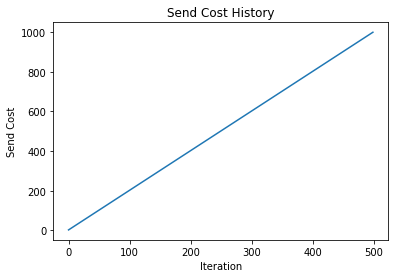

Total send cost: 1000


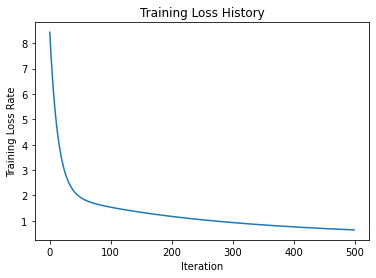

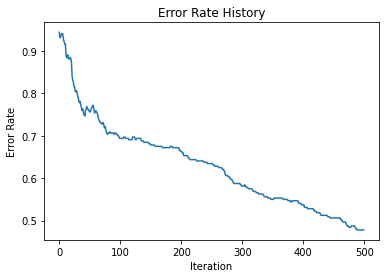

Train error rate: tensor(0.4781)
Test error rate: tensor(0.4500)
=== The training for num_clients is 5 ===
Epoch [1/500], Loss: 17.70442581, Error: 0.9906250238418579, Culminative Send Cost: 10
Epoch [10/500], Loss: 9.84325600, Error: 0.9531250000000000, Culminative Send Cost: 100
Epoch [20/500], Loss: 5.52041340, Error: 0.9093750119209290, Culminative Send Cost: 200
Epoch [30/500], Loss: 3.45686674, Error: 0.8406249880790710, Culminative Send Cost: 300
Epoch [40/500], Loss: 2.46069551, Error: 0.7749999761581421, Culminative Send Cost: 400
Epoch [50/500], Loss: 1.96919000, Error: 0.7781249880790710, Culminative Send Cost: 500
Epoch [60/500], Loss: 1.71667361, Error: 0.7531250119209290, Culminative Send Cost: 600
Epoch [70/500], Loss: 1.57769561, Error: 0.7281249761581421, Culminative Send Cost: 700
Epoch [80/500], Loss: 1.49300301, Error: 0.7343750000000000, Culminative Send Cost: 800
Epoch [90/500], Loss: 1.43459535, Error: 0.7375000119209290, Culminative Send Cost: 900
Epoch [100/500

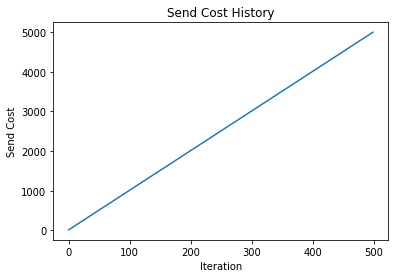

Total send cost: 5000


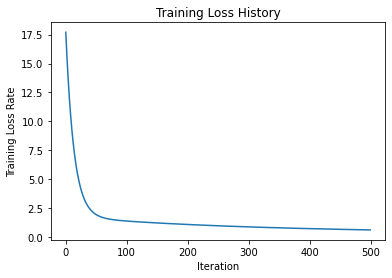

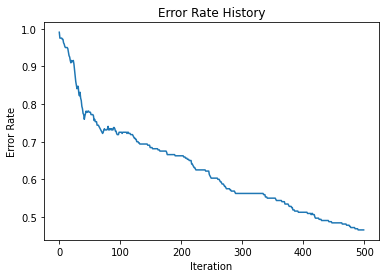

Train error rate: tensor(0.4656)
Test error rate: tensor(0.4500)
=== The training for num_clients is 10 ===
Epoch [1/500], Loss: 17.01663589, Error: 0.9875000119209290, Culminative Send Cost: 20
Epoch [10/500], Loss: 9.49220562, Error: 0.9624999761581421, Culminative Send Cost: 200
Epoch [20/500], Loss: 5.34604645, Error: 0.9312499761581421, Culminative Send Cost: 400
Epoch [30/500], Loss: 3.35895729, Error: 0.8625000119209290, Culminative Send Cost: 600
Epoch [40/500], Loss: 2.39273906, Error: 0.8125000000000000, Culminative Send Cost: 800
Epoch [50/500], Loss: 1.90996516, Error: 0.7718750238418579, Culminative Send Cost: 1000
Epoch [60/500], Loss: 1.65683043, Error: 0.7250000238418579, Culminative Send Cost: 1200
Epoch [70/500], Loss: 1.51342189, Error: 0.7093750238418579, Culminative Send Cost: 1400
Epoch [80/500], Loss: 1.42304933, Error: 0.6999999880790710, Culminative Send Cost: 1600
Epoch [90/500], Loss: 1.35886872, Error: 0.6812499761581421, Culminative Send Cost: 1800
Epoch [1

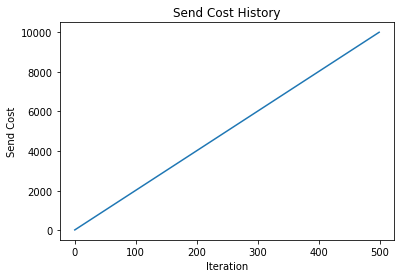

Total send cost: 10000


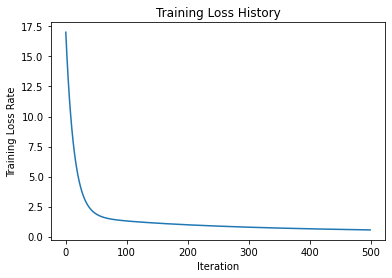

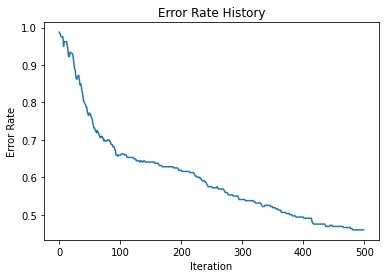

Train error rate: tensor(0.4594)
Test error rate: tensor(0.4125)
=== The training for num_clients is 15 ===
Epoch [1/500], Loss: 12.24441242, Error: 0.9562500119209290, Culminative Send Cost: 30
Epoch [10/500], Loss: 7.15932703, Error: 0.9312499761581421, Culminative Send Cost: 300
Epoch [20/500], Loss: 4.34628201, Error: 0.8687499761581421, Culminative Send Cost: 600
Epoch [30/500], Loss: 2.98906708, Error: 0.8156250119209290, Culminative Send Cost: 900
Epoch [40/500], Loss: 2.32133341, Error: 0.7875000238418579, Culminative Send Cost: 1200
Epoch [50/500], Loss: 1.98061597, Error: 0.7843750119209290, Culminative Send Cost: 1500
Epoch [60/500], Loss: 1.79546356, Error: 0.7718750238418579, Culminative Send Cost: 1800
Epoch [70/500], Loss: 1.68475842, Error: 0.7656250000000000, Culminative Send Cost: 2100
Epoch [80/500], Loss: 1.61010492, Error: 0.7562500238418579, Culminative Send Cost: 2400
Epoch [90/500], Loss: 1.55331230, Error: 0.7437499761581421, Culminative Send Cost: 2700
Epoch [

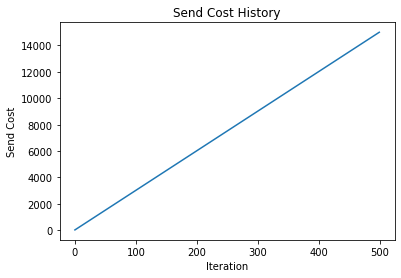

Total send cost: 15000


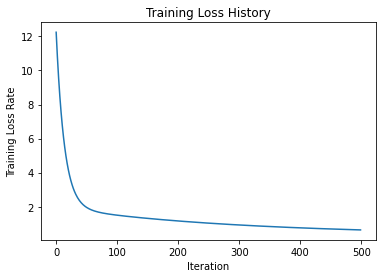

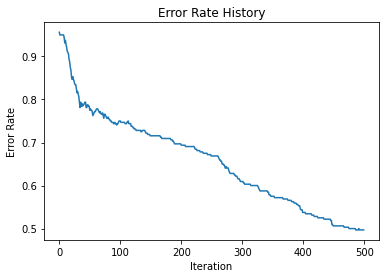

Train error rate: tensor(0.4969)
Test error rate: tensor(0.4375)
=== The training for num_clients is 20 ===
Epoch [1/500], Loss: 12.75738049, Error: 0.9687500000000000, Culminative Send Cost: 40
Epoch [10/500], Loss: 7.42832565, Error: 0.9312499761581421, Culminative Send Cost: 400
Epoch [20/500], Loss: 4.48632717, Error: 0.8750000000000000, Culminative Send Cost: 800
Epoch [30/500], Loss: 3.07045269, Error: 0.8156250119209290, Culminative Send Cost: 1200
Epoch [40/500], Loss: 2.37603998, Error: 0.7875000238418579, Culminative Send Cost: 1600
Epoch [50/500], Loss: 2.02318144, Error: 0.7781249880790710, Culminative Send Cost: 2000
Epoch [60/500], Loss: 1.83248544, Error: 0.7593749761581421, Culminative Send Cost: 2400
Epoch [70/500], Loss: 1.71922565, Error: 0.7468749880790710, Culminative Send Cost: 2800
Epoch [80/500], Loss: 1.64336526, Error: 0.7593749761581421, Culminative Send Cost: 3200
Epoch [90/500], Loss: 1.58596504, Error: 0.7500000000000000, Culminative Send Cost: 3600
Epoch 

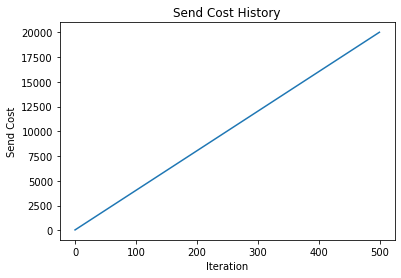

Total send cost: 20000


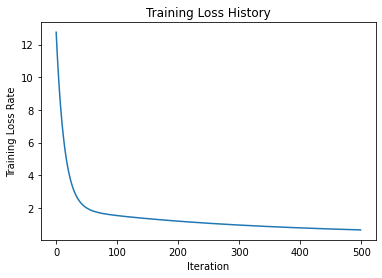

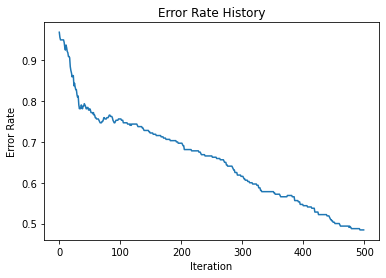

Train error rate: tensor(0.4844)
Test error rate: tensor(0.4375)
=== The Experiment Result ===
Current Dataset: BMI Datset
Vanilia Gradient Descent


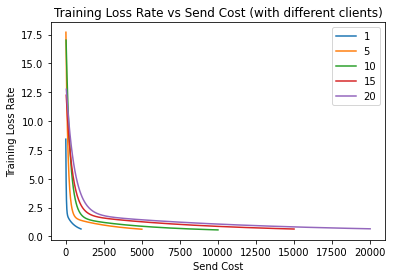

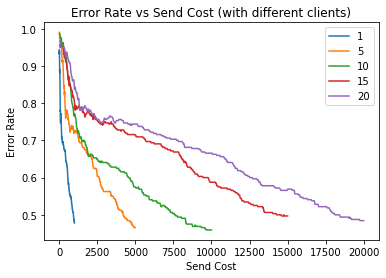

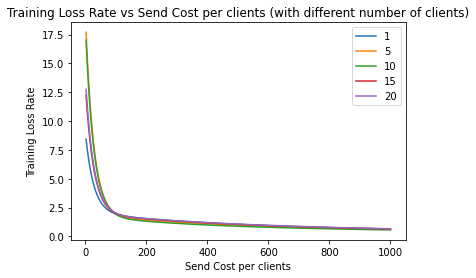

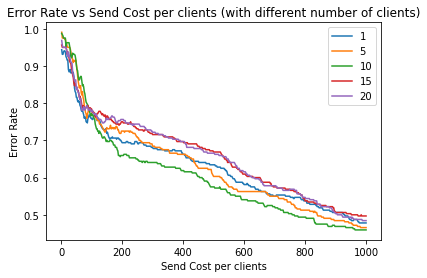

<Figure size 432x288 with 0 Axes>

In [83]:
### Experiment for num_clients with Vanilia Gradient Descent

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs
learning_rate = learning_rate_preset
num_epochs = 500
num_clients_list = [1,5,10,15,20]
local_update_epochs_list = [1]

# Cost History Total
num_clients_list_size = len(num_clients_list)
local_update_epochs_list_size = len(local_update_epochs_list)
loss_cost_history_total = []
error_cost_history_total = []
send_cost_history_total = []

# Compare the num_clients
local_update_epochs = local_update_epochs_list[0]
for num_clients in num_clients_list:
    print(f'=== The training for num_clients is {num_clients} ===')
    FedLearnTrainGDVanilia(num_clients, local_update_epochs, loss_cost_history_total, error_cost_history_total, send_cost_history_total)

print(f'=== The Experiment Result ===')
# Show Dataset Name
print(f'Current Dataset: {dataset_name}')
print("Vanilia Gradient Descent")

# Plot the training loss rate between cost history with clients
for i in range(num_clients_list_size):
    plt.plot(send_cost_history_total[i], loss_cost_history_total[i])
plt.xlabel("Send Cost")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss Rate vs Send Cost (with different clients)")
plt.legend(num_clients_list)
plt.show()
plt.savefig(f'Loss_VS_SendCost_num_clients_{dataset_name}_VGD.png')

# Plot the error rate between cost history with clients
for i in range(num_clients_list_size):
    plt.plot(send_cost_history_total[i], error_cost_history_total[i])
plt.xlabel("Send Cost")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Send Cost (with different clients)")
plt.legend(num_clients_list)
plt.show()
plt.savefig(f'ErrorRate_VS_SendCost_num_clients_{dataset_name}_VGD.png')

# Plot the training loss rate between cost history with num_clients per clients
min_cost_list = send_cost_history_total[0]
for sublist in send_cost_history_total:
    if len(sublist) < len(min_cost_list):
        min_cost_list = sublist
for i in range(num_clients_list_size):
    plt.plot(min_cost_list, loss_cost_history_total[i])
plt.xlabel("Send Cost per clients")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss Rate vs Send Cost per clients (with different number of clients)")
plt.legend(num_clients_list)
plt.show()
plt.savefig(f'Loss_vs_Send_Cost_num_clients_{dataset_name}_VGD_per_clients.png')

# Plot the training loss rate between cost history with num_clients per clients
min_cost_list = send_cost_history_total[0]
for sublist in send_cost_history_total:
    if len(sublist) < len(min_cost_list):
        min_cost_list = sublist
for i in range(num_clients_list_size):
    plt.plot(min_cost_list, error_cost_history_total[i])
plt.xlabel("Send Cost per clients")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Send Cost per clients (with different number of clients)")
plt.legend(num_clients_list)
plt.show()
plt.savefig(f'ErrorRate_vs_Send_Cost_num_clients_{dataset_name}_VGD_per_clients.png')

**Experiment with number of clients of Stochastic Gradient Descent**

Current Dataset: BMI Datset
=== The training for num_clients is 1 ===
Epoch [1/100], Loss: 1.93698668, Error: 0.7781249880790710, Culminative Send Cost: 2
Epoch [10/100], Loss: 0.53537738, Error: 0.4499999880790710, Culminative Send Cost: 20
Epoch [20/100], Loss: 0.33600038, Error: 0.4031249880790710, Culminative Send Cost: 40
Epoch [30/100], Loss: 0.30820838, Error: 0.3906250000000000, Culminative Send Cost: 60
Epoch [40/100], Loss: 0.30383557, Error: 0.3781250119209290, Culminative Send Cost: 80
Epoch [50/100], Loss: 0.30309880, Error: 0.3812499940395355, Culminative Send Cost: 100
Epoch [60/100], Loss: 0.30299744, Error: 0.3843750059604645, Culminative Send Cost: 120
Epoch [70/100], Loss: 0.30301294, Error: 0.3843750059604645, Culminative Send Cost: 140
Epoch [80/100], Loss: 0.30296150, Error: 0.3812499940395355, Culminative Send Cost: 160
Epoch [90/100], Loss: 0.30297726, Error: 0.3843750059604645, Culminative Send Cost: 180
Epoch [100/100], Loss: 0.30307600, Error: 0.3874999880790

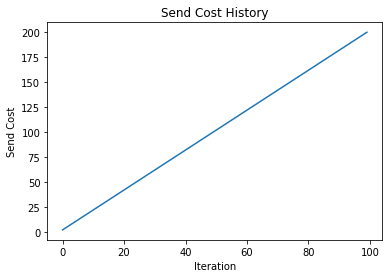

Total send cost: 200


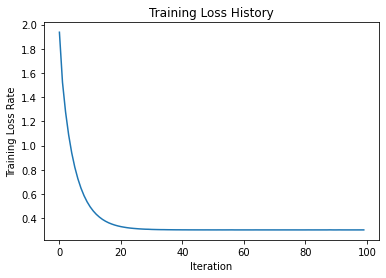

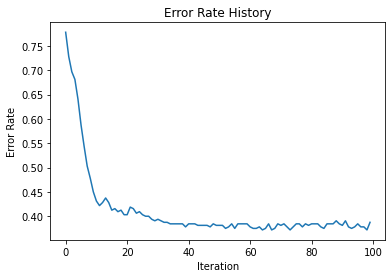

Train error rate: tensor(0.3875)
Test error rate: tensor(0.3625)
=== The training for num_clients is 5 ===
Epoch [1/100], Loss: 1.54474425, Error: 0.7624999880790710, Culminative Send Cost: 10
Epoch [10/100], Loss: 0.46759987, Error: 0.4312500059604645, Culminative Send Cost: 100
Epoch [20/100], Loss: 0.32688665, Error: 0.4031249880790710, Culminative Send Cost: 200
Epoch [30/100], Loss: 0.30670434, Error: 0.3937500119209290, Culminative Send Cost: 300
Epoch [40/100], Loss: 0.30357987, Error: 0.3874999880790710, Culminative Send Cost: 400
Epoch [50/100], Loss: 0.30308557, Error: 0.3781250119209290, Culminative Send Cost: 500
Epoch [60/100], Loss: 0.30300665, Error: 0.3843750059604645, Culminative Send Cost: 600
Epoch [70/100], Loss: 0.30305600, Error: 0.3843750059604645, Culminative Send Cost: 700
Epoch [80/100], Loss: 0.30307707, Error: 0.3718749880790710, Culminative Send Cost: 800
Epoch [90/100], Loss: 0.30296522, Error: 0.3812499940395355, Culminative Send Cost: 900


KeyboardInterrupt: 

In [84]:
### Experiment for num_clients with Stochastic Gradient Descent

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs
learning_rate = learning_rate_preset
num_epochs = 100
batch_size = batch_size_preset
num_clients_list = [1,5,10,15,20]
local_update_epochs_list = [2]

# Cost History Total
num_clients_list_size = len(num_clients_list)
local_update_epochs_list_size = len(local_update_epochs_list)
loss_cost_history_total = []
error_cost_history_total = []
send_cost_history_total = []

# Compare the num_clients
local_update_epochs = local_update_epochs_list[0]
for num_clients in num_clients_list:
    print(f'=== The training for num_clients is {num_clients} ===')
    FedLearnTrainGDStochastic(num_clients, local_update_epochs, loss_cost_history_total, error_cost_history_total, send_cost_history_total)

print(f'=== The Experiment Result ===')
# Show Dataset Name
print(f'Current Dataset: {dataset_name}')
print("Stochastic Gradient Descent")

# Plot the training loss rate between cost history with clients
for i in range(num_clients_list_size):
    plt.plot(send_cost_history_total[i], loss_cost_history_total[i])
plt.xlabel("Send Cost")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss Rate vs Send Cost (with different clients)")
plt.legend(num_clients_list)
plt.show()
plt.savefig(f'Loss_VS_SendCost_num_clients_{dataset_name}_SGD.png')

# Plot the error rate between cost history with clients
for i in range(num_clients_list_size):
    plt.plot(send_cost_history_total[i], error_cost_history_total[i])
plt.xlabel("Send Cost")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Send Cost (with different clients)")
plt.legend(num_clients_list)
plt.show()
plt.savefig(f'ErrorRate_VS_SendCost_num_clients_{dataset_name}_SGD.png')

# Plot the training loss rate between cost history with num_clients per clients
min_cost_list = send_cost_history_total[0]
for sublist in send_cost_history_total:
    if len(sublist) < len(min_cost_list):
        min_cost_list = sublist
for i in range(num_clients_list_size):
    plt.plot(min_cost_list, loss_cost_history_total[i])
plt.xlabel("Send Cost per clients")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss Rate vs Send Cost per clients (with different number of clients)")
plt.legend(num_clients_list)
plt.show()
plt.savefig(f'Loss_vs_Send_Cost_num_clients_{dataset_name}_SGD_per_clients.png')

# Plot the training loss rate between cost history with num_clients per clients
min_cost_list = send_cost_history_total[0]
for sublist in send_cost_history_total:
    if len(sublist) < len(min_cost_list):
        min_cost_list = sublist
for i in range(num_clients_list_size):
    plt.plot(min_cost_list, error_cost_history_total[i])
plt.xlabel("Send Cost per clients")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Send Cost per clients (with different number of clients)")
plt.legend(num_clients_list)
plt.show()
plt.savefig(f'ErrorRate_vs_Send_Cost_num_clients_{dataset_name}_SGD_per_clients.png')

**Experiment with local update epochs of Vanilia Gradient Descent**

In [ ]:
### Experiment for local_update_epochs with Vanilia Gradient Descent

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs
learning_rate = learning_rate_preset
num_epochs = 1000
num_clients_list = [5]
local_update_epochs_list = [1,2,3,4,5]

# Cost History Total
num_clients_list_size = len(num_clients_list)
local_update_epochs_list_size = len(local_update_epochs_list)
loss_cost_history_total = []
error_cost_history_total = []
send_cost_history_total = []

# Compare the local_update_epochs
num_clients = num_clients_list[0]
for local_update_epochs in local_update_epochs_list:
    print(f'=== The training for local_update_epochs is {local_update_epochs} ===')
    FedLearnTrainGDVanilia(num_clients, local_update_epochs, loss_cost_history_total, error_cost_history_total, send_cost_history_total)

print(f'=== The Experiment Result ===')
# Show Dataset Name
print(f'Current Dataset: {dataset_name}')
print("Vanilia Gradient Descent")

# Plot the training loss rate between cost history with local update epochs
for i in range(local_update_epochs_list_size):
    plt.plot(send_cost_history_total[i], loss_cost_history_total[i])
plt.xlabel("Send Cost")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss Rate vs Send Cost (with different local update epochs)")
plt.legend(local_update_epochs_list)
plt.show()
plt.savefig(f'Loss_VS_SendCost_local_update_epochs_{dataset_name}_VGD.png')

# Plot the error rate between cost history with local update epochs
for i in range(local_update_epochs_list_size):
    plt.plot(send_cost_history_total[i], error_cost_history_total[i])
plt.xlabel("Send Cost")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Send Cost (with different local update epochs)")
plt.legend(local_update_epochs_list)
plt.show()
plt.savefig(f'ErrorRate_VS_SendCost_local_update_epochs_{dataset_name}_VGD.png')

**Experiment with local update epochs of Stochastic Gradient Descent**

In [ ]:
### Experiment for local_update_epochs with Stochastic Gradient Descent

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs
learning_rate = learning_rate_preset
num_epochs = 500
batch_size = batch_size_preset
num_clients_list = [2]
local_update_epochs_list = [1,2,3,4,5]

# Cost History Total
num_clients_list_size = len(num_clients_list)
local_update_epochs_list_size = len(local_update_epochs_list)
loss_cost_history_total = []
error_cost_history_total = []
send_cost_history_total = []

# Compare the local_update_epochs
num_clients = num_clients_list[0]
for local_update_epochs in local_update_epochs_list:
    print(f'=== The training for local_update_epochs is {local_update_epochs} ===')
    FedLearnTrainGDStochastic(num_clients, local_update_epochs, loss_cost_history_total, error_cost_history_total, send_cost_history_total)

print(f'=== The Experiment Result ===')
# Show Dataset Name
print(f'Current Dataset: {dataset_name}')
print("Stochastic Gradient Descent")

# Plot the training loss rate between cost history with local update epochs
for i in range(local_update_epochs_list_size):
    plt.plot(send_cost_history_total[i], loss_cost_history_total[i])
plt.xlabel("Send Cost")
plt.ylabel("Training Loss Rate")
plt.title("Training Loss Rate vs Send Cost (with different local update epochs)")
plt.legend(local_update_epochs_list)
plt.show()
plt.savefig(f'Loss_VS_SendCost_local_update_epochs_{dataset_name}_SGD.png')

# Plot the error rate between cost history with local update epochs
for i in range(local_update_epochs_list_size):
    plt.plot(send_cost_history_total[i], error_cost_history_total[i])
plt.xlabel("Send Cost")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Send Cost (with different local update epochs)")
plt.legend(local_update_epochs_list)
plt.show()
plt.savefig(f'ErrorRate_VS_SendCost_local_update_epochs_{dataset_name}_SGD.png')

## Section 2 Non-Linear Training Model
Here we focus on dataset requires mainly non-linear training algorithms.

### Section 2.0 Data Loading and Preprocessing

Here we load the data for the expriements.

**MNIST Dataset**

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.

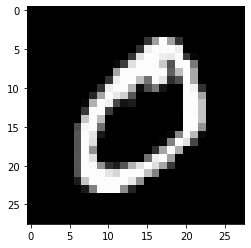

tensor(0.)


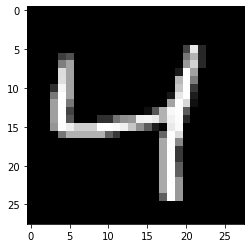

tensor(4.)


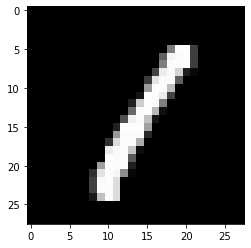

tensor(1.)


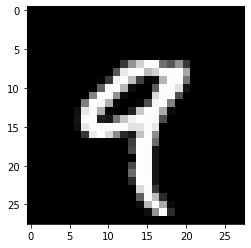

tensor(9.)


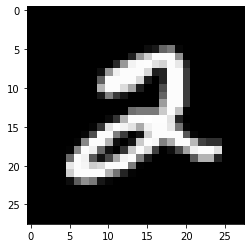

tensor(2.)


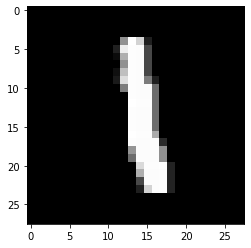

tensor(1.)


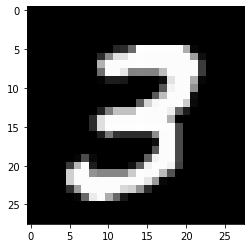

tensor(3.)


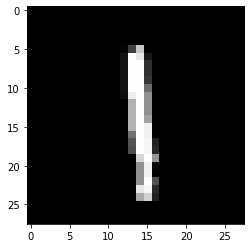

tensor(1.)


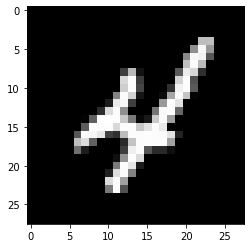

tensor(4.)


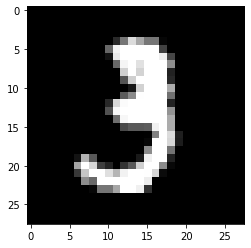

tensor(3.)


In [64]:
### MNIST Dataset

# Loading training data
dataset = pd.read_csv("mnist_train.csv")
dataset = dataset.to_numpy()
X_train = dataset[:1000, 1:].astype(np.int32)
y_train = dataset[:1000, 0].astype(np.int32)

# Loading testing data
dataset = pd.read_csv("mnist_test.csv")
dataset = dataset.to_numpy()
X_test = dataset[:1000, 1:].astype(np.int32)
y_test = dataset[:1000, 0].astype(np.int32)

# Translation of data  
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
y_train = y_train.astype('float32') 
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
y_test = y_test.astype('float32') 
print(X_train)
print(y_train)

# Normalize data set
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train_normalized)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test_normalized)
y_test_tensor = torch.from_numpy(y_test)
print(X_train_tensor)
print(y_train_tensor)
print(X_test_tensor)
print(y_test_tensor)
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

# Learning Rate and Batch size
dataset_name = "MNIST Datset"
learning_rate_preset = 0.01
batch_size_preset = 100
CNN_input_shape_preset = (-1, 1, 28, 28)

# Number of samples, features, and classes
num_samples_preset  = X_train_tensor.size()[0]
num_features_preset = X_train_tensor.size()[1]
num_classes_preset = len(torch.unique(y_train_tensor))

# Translate the tensor to dataset
MINST_train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
MINST_test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Translate to DataLoader
train_loader = torch.utils.data.DataLoader(MINST_train_dataset, batch_size = batch_size_preset, shuffle = True)
test_loader = torch.utils.data.DataLoader(MINST_test_dataset, batch_size = batch_size_preset, shuffle = True)

# Visualize the first 10 images
for i in range(10):
    plt.imshow(X_train_tensor[i], cmap='gray')
    plt.show()
    print(y_train_tensor[i])

**CIFAR-10 Dataset**

[[[[ 59.  62.  63.]
   [ 43.  46.  45.]
   [ 50.  48.  43.]
   ...
   [158. 132. 108.]
   [152. 125. 102.]
   [148. 124. 103.]]

  [[ 16.  20.  20.]
   [  0.   0.   0.]
   [ 18.   8.   0.]
   ...
   [123.  88.  55.]
   [119.  83.  50.]
   [122.  87.  57.]]

  [[ 25.  24.  21.]
   [ 16.   7.   0.]
   [ 49.  27.   8.]
   ...
   [118.  84.  50.]
   [120.  84.  50.]
   [109.  73.  42.]]

  ...

  [[208. 170.  96.]
   [201. 153.  34.]
   [198. 161.  26.]
   ...
   [160. 133.  70.]
   [ 56.  31.   7.]
   [ 53.  34.  20.]]

  [[180. 139.  96.]
   [173. 123.  42.]
   [186. 144.  30.]
   ...
   [184. 148.  94.]
   [ 97.  62.  34.]
   [ 83.  53.  34.]]

  [[177. 144. 116.]
   [168. 129.  94.]
   [179. 142.  87.]
   ...
   [216. 184. 140.]
   [151. 118.  84.]
   [123.  92.  72.]]]


 [[[154. 177. 187.]
   [126. 137. 136.]
   [105. 104.  95.]
   ...
   [ 91.  95.  71.]
   [ 87.  90.  71.]
   [ 79.  81.  70.]]

  [[140. 160. 169.]
   [145. 153. 154.]
   [125. 125. 118.]
   ...
   [ 96.  99.  78.]
 

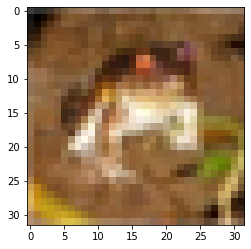

tensor(6.)


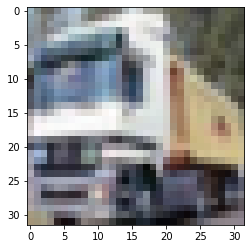

tensor(9.)


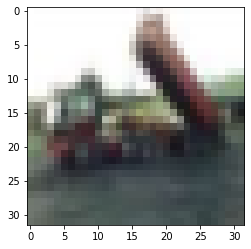

tensor(9.)


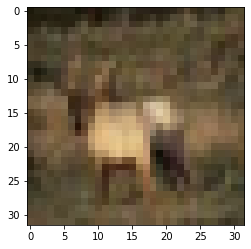

tensor(4.)


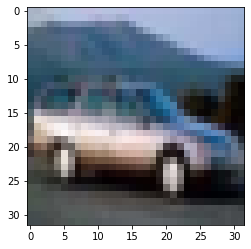

tensor(1.)


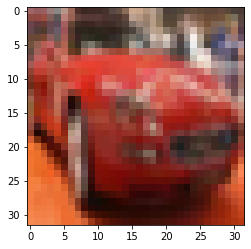

tensor(1.)


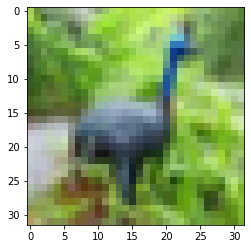

tensor(2.)


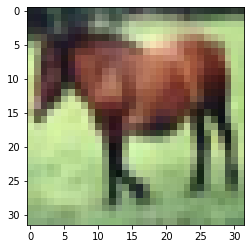

tensor(7.)


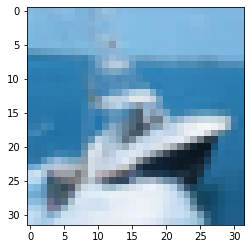

tensor(8.)


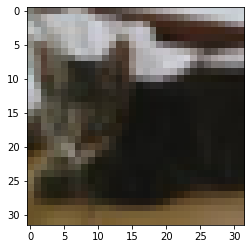

tensor(3.)


In [68]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data(directory):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    
    # Load data batches
    for i in range(1, 6):
        train_batch_file = os.path.join(directory, 'data_batch_{}'.format(i))
        train_data_dict = unpickle(train_batch_file)
        train_batch_images = train_data_dict[b'data']
        train_batch_labels = train_data_dict[b'labels']
        
        # Reshape the image data
        train_batch_images = train_batch_images.reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
        
        train_images.append(train_batch_images)
        train_labels.extend(train_batch_labels)
    
    # Load test batch
    test_batch_file = os.path.join(directory, 'test_batch')
    test_data_dict = unpickle(test_batch_file)
    test_batch_images = test_data_dict[b'data']
    test_batch_labels = test_data_dict[b'labels']
    
    # Reshape the test image data
    test_batch_images = test_batch_images.reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))

    test_images.append(test_batch_images)
    test_labels.extend(test_batch_labels)
    
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.array(train_labels)
    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.array(test_labels)
    
    return train_images, train_labels, test_images, test_labels

# Specify the path to the 'cifar-10-batches-py' directory
data_directory = 'cifar-10-batches-py'

# Load CIFAR-10 data
train_images, train_labels, test_images, test_labels = load_cifar10_data(data_directory)

# Input to X and y
X_train = train_images.astype(np.int32)
y_train = train_labels.astype(np.int32)
X_test = test_images.astype(np.int32)
y_test = test_labels.astype(np.int32)

# Translation of data
X_train = X_train.astype('float32')
y_train = y_train.astype('float32') 
X_test = X_test.astype('float32')
y_test = y_test.astype('float32') 
print(X_train)
print(y_train)

# Normalize data set
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train_normalized[:100])
y_train_tensor = torch.from_numpy(y_train[:100])
X_test_tensor = torch.from_numpy(X_test_normalized)
y_test_tensor = torch.from_numpy(y_test)
print(X_train_tensor)
print(y_train_tensor)
print(X_test_tensor)
print(y_test_tensor)
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

# Learning Rate and Batch size
dataset_name = "CIFAR-10 Datset"
learning_rate_preset = 0.01
batch_size_preset = 100
CNN_input_shape_preset = (-1, 3, 32, 32)

# Number of samples, features, and classes
num_samples_preset  = X_train_tensor.size()[0]
num_features_preset = X_train_tensor.size()[1]
num_classes_preset = len(torch.unique(y_train_tensor))

# Translate the tensor to dataset
CIFAR_10_train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
CIFAR_10_test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Translate to DataLoader
train_loader = torch.utils.data.DataLoader(CIFAR_10_train_dataset, batch_size = batch_size_preset, shuffle = True)
test_loader = torch.utils.data.DataLoader(CIFAR_10_test_dataset, batch_size = batch_size_preset, shuffle = True)

# Visualize the first 10 images
for i in range(10):
    plt.imshow(X_train_tensor[i])
    plt.show()
    print(y_train_tensor[i])

### Section 2.1 Non-Linear Neural Networks

**Convolutional Neural Network (CNN)**

In [53]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 7 * 7, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return torch.squeeze(x)
    
class ConvolutionalNeuralNetwork_CIFAR10(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.activation_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
    def forward(self, x):
        x = self.activation_stack(x)
        return torch.squeeze(x)

**Client Device for CNN**

In [60]:
# Define a custom class for each client so they can update separately
class ClientDevice:
    def __init__(self, model, optimizer, criterion, train_dataloader, test_dataloader=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader

    def load_global_weights(self, global_weights):
        self.model.load_state_dict(global_weights)

    def get_local_weights(self):
        return self.model.state_dict()
    
    def update_weights(self, num_epochs, iterate_func):
        self.model.train()
        loss_history, error_history = iterate_func(self.model, self.train_dataloader, num_epochs, self.optimizer, self.criterion, show_history=False, training=True)
        return self.model.state_dict(), loss_history, error_history

# Establish client devices
def establish_client_devices(num_clients, train_dataloader_list, test_dataloader_list, model_list, optimizer_list, criterion_list):
    # Establish client devices
    client_device = [None] * num_clients
    client_model = [None] * num_clients
    client_optimizer = [None] * num_clients
    client_criterion = [None] * num_clients
    client_weights = [None] * num_clients
    for client in range(num_clients):
        client_model[client] = model_list[client]
        client_optimizer[client] = optimizer_list[client]
        client_criterion[client] = criterion_list[client]
        client_weights[client] = client_model[client].state_dict()
        client_device[client] = ClientDevice(client_model[client], client_optimizer[client], client_criterion[client], train_dataloader_list[client], test_dataloader_list[client])
    return client_device

**CNN Training and Testing Algorithm**

In [10]:
def iterate_CNN_model(model, dataset_loader, num_epochs, optimizer, criterion, show_history=True, training=True):
    loss_history = []
    error_history = []
    for epoch in range(num_epochs):
        single_iteration_count = 0.00
        batch_iteration_count = 0.00
        loss_count = 0.00
        error_count = 0.00
        for i, (images, labels) in enumerate(dataset_loader):
            # Define variables
            X_batch = Variable(images.view(CNN_input_shape))
            y_batch = Variable(labels)

            # Forward propagation to obtain the predicted output
            outputs = model(X_batch)

            # Calculate the loss
            loss = criterion(outputs, y_batch.long())
            
            # Backward propagation and optimization
            if training is True:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Record the iteration used
            single_iteration_count += 1
            batch_iteration_count += len(y_batch)

            # Record the loss
            loss_count += loss.data.detach().numpy()

            # Record the error rate
            predicted = torch.max(outputs.data, 1)[1]
            error_count += (predicted != y_batch).float().sum()
        
        # Summarize the loss rate
        loss_rate = loss_count / float(single_iteration_count)
        loss_history.append(loss_rate)

        # Summarize the error rate
        train_error_rate = error_count / float(batch_iteration_count)
        error_history.append(train_error_rate)

        # Print the summarized loss and error every specific epochs
        if show_history is True and ((epoch + 1) % 10 == 0 or epoch == 0):
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss_rate.item():.8f}, Average Error: {train_error_rate:.16f}')

    return loss_history, error_history

def fit_CNN_model(model, train_loader, test_loader, num_epochs, optimizer, criterion, show_history=True):
    # Model becomes "Train Mode"
    model.train()
    if test_loader is not None:
       print("!-- Training Session --!")
    train_loss_history, train_error_history = iterate_CNN_model(model, train_loader, num_epochs, optimizer, criterion, show_history=show_history, training=True)
    
    if test_loader is not None:
        # Model becomes "Eval Mode"
        model.eval()
        print("!-- Testing Session --!")
        test_loss_history, test_error_history = iterate_CNN_model(model, test_loader, num_epochs, optimizer, criterion, show_history=show_history, training=True)
    
    # Experiment Result
    print("!-- CNN Model Result --!")

    # Print learned parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
            
    # Plot the training and testing loss history
    if test_loader is not None:
        plt.plot(train_loss_history, label='Training Loss')
        plt.plot(test_loss_history, label='Testing Loss')
        plt.legend()
    else:
        plt.plot(train_loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Average Training Loss Rate")
    plt.title("Average Training Loss History")
    plt.show()

    # Plot the error rate history
    if test_loader is not None:
        plt.plot(train_error_history, label='Training Error Rate')
        plt.plot(test_error_history, label='Testing Error Rate')
        plt.legend()
    else:
        plt.plot(train_error_history)
    plt.xlabel("Epochs")
    plt.ylabel("Average Error Rate")
    plt.title("Average Error Rate History")
    plt.show()

**Train the CNN model**

Current Dataset: CIFAR-10 Datset
ConvolutionalNeuralNetwork_CIFAR10(
  (activation_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15):

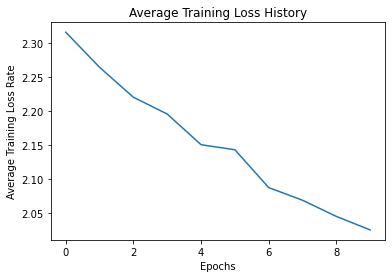

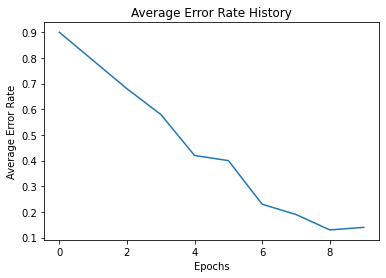

In [54]:
# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the learning rate and number of epochs
learning_rate = learning_rate_preset
num_epochs = 10

# Define neural network model, loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
if dataset_name == "CIFAR-10 Datset":
    model = ConvolutionalNeuralNetwork_CIFAR10(num_classes_preset)
else:
    model = ConvolutionalNeuralNetwork(num_classes_preset)
CNN_input_shape = CNN_input_shape_preset
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0)
print(model)

# Perform training
fit_CNN_model(model, train_loader, None, num_epochs, optimizer, criterion, show_history=True)

### Section 2.2 Federated Learning Algorithms

In [55]:
### Federated Learning Training with stochastic gradient descent method
def iterate_FedLearn_model(model, dataset_loader, num_epochs, optimizer, criterion, num_clients, local_update_epochs, client_device, iterate_func=iterate_CNN_model, aggregate_func=Federated_Averaging, show_history=True, training = True):
    # Initialize cost history for recording
    loss_cost_history = []
    error_cost_history = []
    send_cost_history = []
    send_cost = 0

    # Initialize global weights
    client_weights = [None] * num_clients
    global_weights = model.state_dict()
    
    # Iteration
    for epoch in range(num_epochs):
        client_weights_total = []
        loss_count = 0.00
        error_count = 0.00

        # Clients local update
        for client in range(num_clients):
            # Transmit the global weight to clients
            client_device[client].load_global_weights(global_weights)

            # Local update
            client_weights[client], local_loss_history, local_error_history = client_device[client].update_weights(local_update_epochs, iterate_func)
            local_loss = sum(local_loss_history) / len(local_loss_history)
            local_error = sum(local_error_history) / len(local_error_history)

            # Send client weights to the server
            send_client_weights(client_weights_total, client_weights[client])
            client_weights_size = sum(value.numel() for value in client_weights[client].values())
            send_cost = send_cost + client_weights_size

            # Send client loss and error to the server (we ignore the cost involved here)
            loss_count += local_loss
            error_count += local_error

        # Aggregate client weights on the server
        aggregated_weights = aggregate_func(client_weights_total)

        # Update global weights with aggregated weights
        global_weights.update(aggregated_weights)
        model.load_state_dict(global_weights)

        # Summarize loss and error
        loss_average = loss_count / num_clients
        train_error_rate_average = error_count / num_clients

        # Record the loss
        loss_cost_history.append(loss_average.item())

        # Record the error rate
        error_cost_history.append(train_error_rate_average)

        # Record the send cost
        send_cost_history.append(send_cost)

        # Print the loss every specific epochs
        if show_history is True and ((epoch + 1) % 1 == 0 or epoch == 0):
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss_average.item():.8f}, Average Error: {train_error_rate_average:.16f}, Culminative Send Cost: {send_cost}')

    return loss_cost_history, error_cost_history, send_cost_history

def fit_FedLearn_model(model, train_loader, test_loader, num_epochs, num_clients, client_setup_func, local_update_epochs, optimizer, criterion, iterate_func, aggregate_func, show_history=True):
    # Preprocess the client data
    #client_dataloader_list = split_dataloader(train_loader, num_clients)

    # This is the alternative for preprocessing, will be changed in the future

    ### Alternative ###
    client_dataloader_list = [] * num_clients
    X_train_client = [None] * num_clients
    y_train_client = [None] * num_clients
    client_row = math.floor( num_samples_preset / num_clients )
    for client in range(num_clients):
        X_train_client[client] = X_train_tensor[(client)*client_row : (client+1)*client_row]
        y_train_client[client] = y_train_tensor[(client)*client_row : (client+1)*client_row]
        
        # Translate the tensor to dataset
        client_train_dataset = torch.utils.data.TensorDataset(X_train_client[client], y_train_client[client])

        # Translate to DataLoader
        client_loader = torch.utils.data.DataLoader(client_train_dataset, batch_size = batch_size_preset, shuffle = True)
        client_dataloader_list.append(client_loader)
    ### Alternative End ###

    # Define the client model, criterion, optimizer, its dataset
    client_model_list = [None] * num_clients
    client_optimizer_list = [None] * num_clients
    client_criterion_list = [None] * num_clients
    client_setup_func(num_clients, client_model_list, client_optimizer_list, client_criterion_list, client_dataloader_list)
    
    # Establish client devices
    client_device = establish_client_devices(num_clients=num_clients, 
                                             train_dataloader_list=client_dataloader_list, 
                                             test_dataloader_list= [None] * num_clients,
                                             model_list=client_model_list, 
                                             optimizer_list=client_optimizer_list,
                                             criterion_list=client_criterion_list)

    # Model becomes "Train Mode"
    model.train()
    if test_loader is not None:
        print("!-- Training Session --!")
    train_loss_history, train_error_history, train_send_cost_history = iterate_FedLearn_model(model=model, dataset_loader=train_loader, 
                                                                                         num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, 
                                                                                         num_clients=num_clients, local_update_epochs=local_update_epochs, client_device=client_device,
                                                                                         iterate_func=iterate_func, aggregate_func=aggregate_func,
                                                                                         show_history=show_history, training = True)

    if test_loader is not None:
        # Model becomes "Eval Mode"
        model.eval()
        print("!-- Testing Session --!")
        test_loss_history, test_error_history, test_send_cost_history = iterate_FedLearn_model(model=model, dataset_loader=test_loader, 
                                                                                         num_epochs=num_epochs, optimizer=optimizer, criterion=criterion, 
                                                                                         num_clients=num_clients, local_update_epochs=local_update_epochs, client_device=client_device,
                                                                                         iterate_func=iterate_func, aggregate_func=aggregate_func,
                                                                                         show_history=show_history, training = False)

    # Print learned parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Plot send cost history
    if test_loader is not None:
        print(f'Total send cost in training: {sum(train_send_cost_history)}')
        print(f'Total send cost in testing: {sum(test_send_cost_history)}')
        plt.plot(train_send_cost_history, label='Training Send Cost')
        plt.plot(test_send_cost_history, label='Testing Send Cost')
        plt.legend()
    else:
        print(f'Total send cost in training: {sum(train_send_cost_history)}')
        plt.plot(train_send_cost_history)
    plt.plot(train_send_cost_history)
    plt.xlabel("Epochs")
    plt.ylabel("Send Cost")
    plt.title("Send Cost History")
    plt.show()
    
    # Plot the training and testing loss history
    if test_loader is not None:
        plt.plot(train_loss_history, label='Training Loss')
        plt.plot(test_loss_history, label='Testing Loss')
        plt.legend()
    else:
        plt.plot(train_loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Average Training Loss Rate")
    plt.title("Average Training Loss History")
    plt.show()

    # Plot the error rate history
    if test_loader is not None:
        plt.plot(train_error_history, label='Training Error Rate')
        plt.plot(test_error_history, label='Testing Error Rate')
        plt.legend()
    else:
        plt.plot(train_error_history)
    plt.xlabel("Epochs")
    plt.ylabel("Average Error Rate")
    plt.title("Average Error Rate History")
    plt.show()

    return train_loss_history, train_error_history, train_send_cost_history

**Federated Learning Expriment Functions**

In [61]:
def experiment_FedLearn_model(global_model_class_setup_func, train_loader, test_loader, num_clients_list, local_update_epochs_list, client_setup_func, iterate_func, aggregate_func, compareClients=False):
    # Cost History Total
    num_clients_list_size = len(num_clients_list)
    local_update_epochs_list_size = len(local_update_epochs_list)
    loss_cost_history_total = []
    error_cost_history_total = []
    send_cost_history_total = []

    if compareClients is True:
        iteration_list = num_clients_list
    else:
        iteration_list = local_update_epochs_list

    for n in range(len(iteration_list)):
        if compareClients is True:
            print(f'=== The training for num_clients is {num_clients_list[n]} ===')
            num_clients = num_clients_list[n]
            local_update_epochs = local_update_epochs_list[0]
        else:
            print(f'=== The training for local_update_epochs is {local_update_epochs_list[n]} ===')
            num_clients = num_clients_list[0]
            local_update_epochs = local_update_epochs_list[n]

        # Define global neural network model, loss criterion and optimizer
        model, criterion, optimizer = global_model_class_setup_func()
        print(model)

        # Perform training
        loss_cost_history, error_cost_history, send_cost_history = fit_FedLearn_model(model, train_loader, test_loader, num_epochs, num_clients, client_setup_func, local_update_epochs, optimizer, criterion, iterate_func, aggregate_func, show_history=True)

        # Record the history of loss, error and send_cost
        loss_cost_history_total.append(loss_cost_history)
        error_cost_history_total.append(error_cost_history)
        send_cost_history_total.append(send_cost_history)

    print(f'=== The Experiment Result ===')
    # Show Dataset Name
    print(f'Current Dataset: {dataset_name}')
    if compareClients is True:
        # Plot the training loss rate between cost history with num_clients
        for i in range(num_clients_list_size):
            plt.plot(send_cost_history_total[i], loss_cost_history_total[i])
        plt.xlabel("Send Cost")
        plt.ylabel("Training Loss Rate")
        plt.title("Training Loss Rate vs Send Cost (with different number of clients)")
        plt.legend(num_clients_list)
        plt.show()
        plt.savefig(f'Loss_vs_Send_Cost_{dataset_name}_num_clients.png')

        # Plot the error rate between cost history with local_update_epochs
        for i in range(num_clients_list_size):
            plt.plot(send_cost_history_total[i], error_cost_history_total[i])
        plt.xlabel("Send Cost")
        plt.ylabel("Error Rate")
        plt.title("Error Rate vs Send Cost (with different number of clients)")
        plt.legend(num_clients_list)
        plt.show()
        plt.savefig(f'ErrorRate_vs_Send_Cost_{dataset_name}_num_clients.png')

        # Plot the training loss rate between cost history with num_clients per clients
        min_cost_list = send_cost_history_total[0]
        for sublist in send_cost_history_total:
            if len(sublist) < len(min_cost_list):
                min_cost_list = sublist
        for i in range(num_clients_list_size):
            plt.plot(min_cost_list, loss_cost_history_total[i])
        plt.xlabel("Send Cost per clients")
        plt.ylabel("Training Loss Rate")
        plt.title("Training Loss Rate vs Send Cost per clients (with different number of clients)")
        plt.legend(num_clients_list)
        plt.show()
        plt.savefig(f'Loss_vs_Send_Cost_{dataset_name}_num_clients_per_clients.png')

        # Plot the training loss rate between cost history with num_clients per clients
        min_cost_list = send_cost_history_total[0]
        for sublist in send_cost_history_total:
            if len(sublist) < len(min_cost_list):
                min_cost_list = sublist
        for i in range(num_clients_list_size):
            plt.plot(min_cost_list, error_cost_history_total[i])
        plt.xlabel("Send Cost per clients")
        plt.ylabel("Error Rate")
        plt.title("Error Rate vs Send Cost per clients (with different number of clients)")
        plt.legend(num_clients_list)
        plt.show()
        plt.savefig(f'ErrorRate_vs_Send_Cost_{dataset_name}_num_clients_per_clients.png')
    else:
        # Plot the training loss rate between cost history with local_update_epochs
        for i in range(local_update_epochs_list_size):
            plt.plot(send_cost_history_total[i], loss_cost_history_total[i])
        plt.xlabel("Send Cost")
        plt.ylabel("Training Loss Rate")
        plt.title("Training Loss Rate vs Send Cost (with different local update epochs)")
        plt.legend(local_update_epochs_list)
        plt.show()
        plt.savefig(f'Loss_vs_Send_Cost_{dataset_name}_local_update_epochs.png')

        # Plot the error rate between cost history with local_update_epochs
        for i in range(local_update_epochs_list_size):
            plt.plot(send_cost_history_total[i], error_cost_history_total[i])
        plt.xlabel("Send Cost")
        plt.ylabel("Error Rate")
        plt.title("Error Rate vs Send Cost (with different local update epochs)")
        plt.legend(local_update_epochs_list)
        plt.show()
        plt.savefig(f'ErrorRate_vs_Send_Cost_{dataset_name}_local_update_epochs.png')

In [62]:
def simple_global_model_func_CNN():
    if dataset_name == "CIFAR-10 Datset":
        model = ConvolutionalNeuralNetwork_CIFAR10(num_classes_preset)
    else:
        model = ConvolutionalNeuralNetwork(num_classes_preset)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0)
    return model, criterion, optimizer

def simple_client_setup_func_CNN(num_clients, client_model_list, client_optimizer_list, client_criterion_list, client_dataloader_list):
    for client in range(num_clients):
        if dataset_name == "CIFAR-10 Datset":
            client_model_list[client] = ConvolutionalNeuralNetwork_CIFAR10(num_classes_preset)
        else:
            client_model_list[client] = ConvolutionalNeuralNetwork(num_classes_preset)
        client_criterion_list[client] = nn.CrossEntropyLoss()
        client_optimizer_list[client] = torch.optim.SGD(client_model_list[client].parameters(), lr=learning_rate)

Current Dataset: CIFAR-10 Datset
=== The training for num_clients is 1 ===
ConvolutionalNeuralNetwork_CIFAR10(
  (activation_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3)

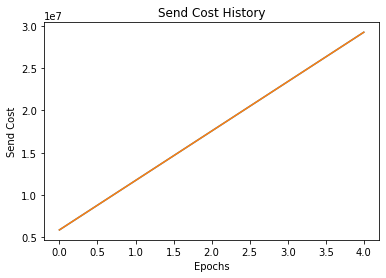

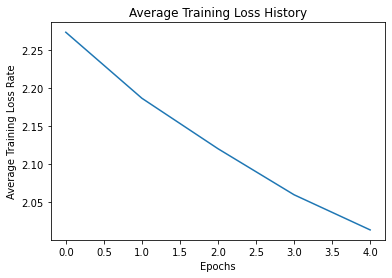

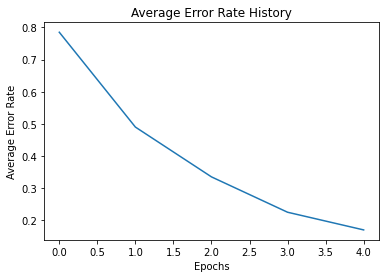

=== The training for num_clients is 5 ===
ConvolutionalNeuralNetwork_CIFAR10(
  (activation_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


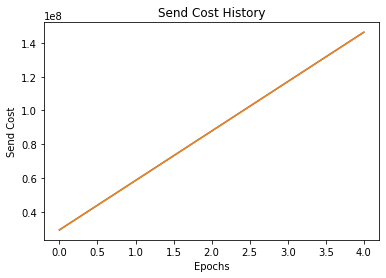

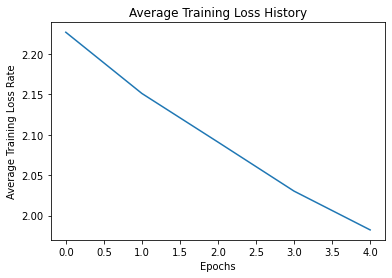

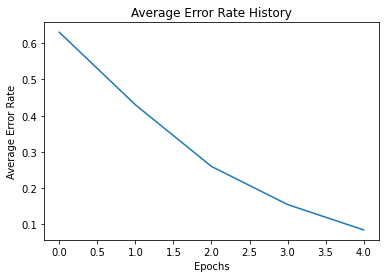

=== The training for num_clients is 10 ===
ConvolutionalNeuralNetwork_CIFAR10(
  (activation_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

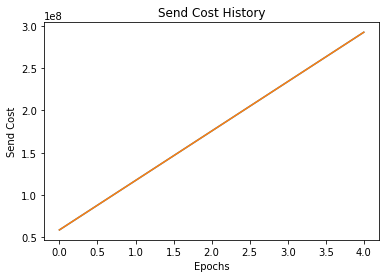

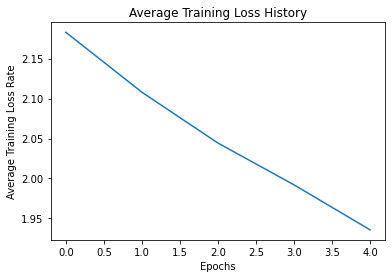

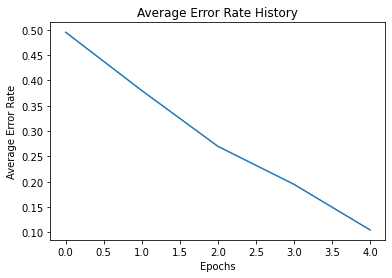

=== The Experiment Result ===
Current Dataset: CIFAR-10 Datset


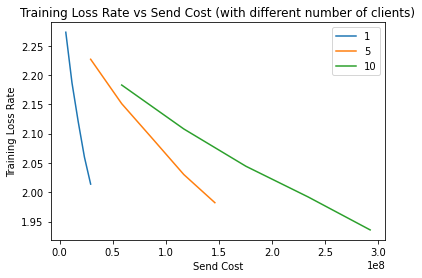

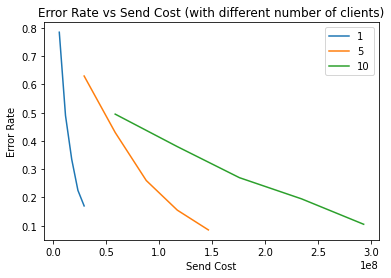

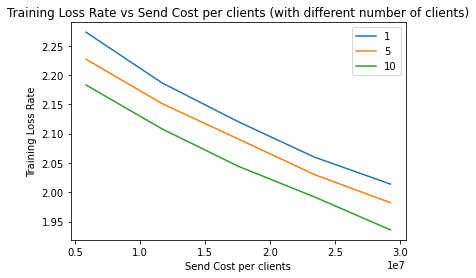

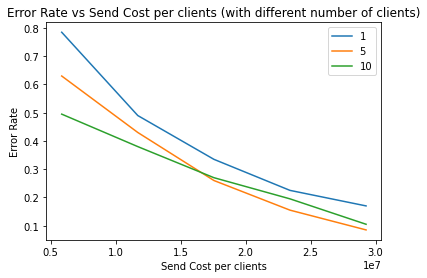

<Figure size 432x288 with 0 Axes>

In [70]:
### Experiment for num_clients with CNN model

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the model parameters
learning_rate = learning_rate_preset
num_epochs = 5
batch_size = batch_size_preset

num_clients_list = [1,5,10]
local_update_epochs_list = [2]

CNN_input_shape = CNN_input_shape_preset

# Experiment
experiment_FedLearn_model(simple_global_model_func_CNN, train_loader, None, num_clients_list, local_update_epochs_list, simple_client_setup_func_CNN, iterate_CNN_model, Federated_Averaging, compareClients=True)

Current Dataset: CIFAR-10 Datset
=== The training for local_update_epochs is 1 ===
ConvolutionalNeuralNetwork_CIFAR10(
  (activation_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_siz

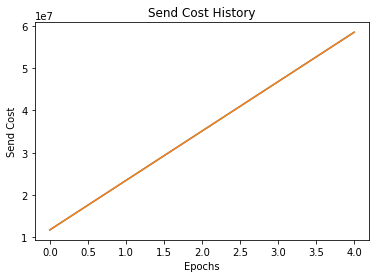

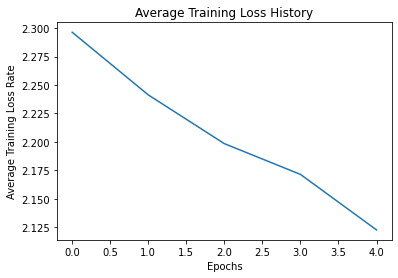

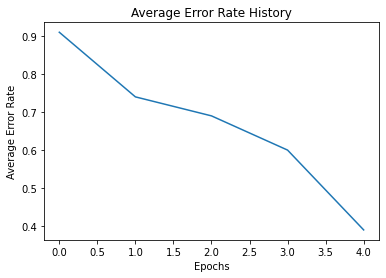

=== The training for local_update_epochs is 2 ===
ConvolutionalNeuralNetwork_CIFAR10(
  (activation_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

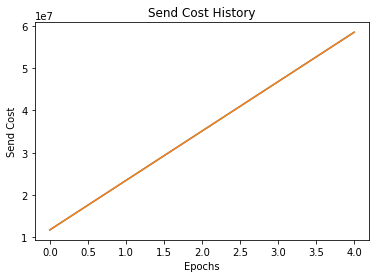

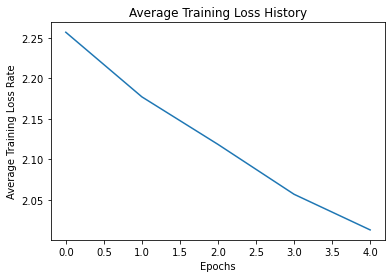

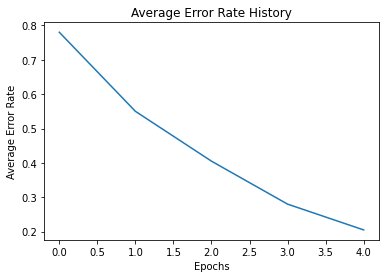

=== The Experiment Result ===
Current Dataset: CIFAR-10 Datset


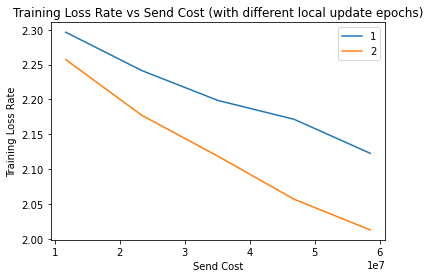

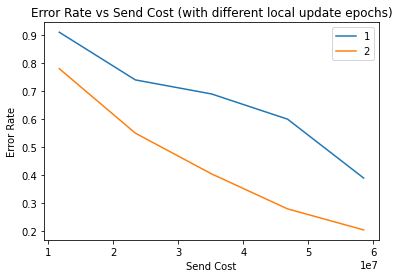

<Figure size 432x288 with 0 Axes>

In [69]:
### Experiment for local_update_epochs with CNN model

# Show Dataset Name
print(f'Current Dataset: {dataset_name}')

# Define the model parameters
learning_rate = learning_rate_preset
num_epochs = 5
batch_size = batch_size_preset

num_clients_list = [2]
local_update_epochs_list = [1,2]

CNN_input_shape = CNN_input_shape_preset

# Experiment
experiment_FedLearn_model(simple_global_model_func_CNN, train_loader, None, num_clients_list, local_update_epochs_list, simple_client_setup_func_CNN, iterate_CNN_model, Federated_Averaging, compareClients=False)